# This file has 2 sections:
## Section 1: Download, clean, and analyze data created by Prof. Moura
## Section 2: Models to represent usage behavior and testing created by German Perea 
### August 17, 2021

## Section 1

In [2]:
# import modules
import csv 
from datetime import datetime, timedelta
import time
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)


In [3]:
# Query AWS DynamoDB for engineRecords

# Set start and end time for query
start_dt = datetime(2020, 11, 5, 5, 0)
start_unix = int(time.mktime(start_dt.timetuple()))
print("Start Time: ", start_unix)

# Update the date from to 03/24 to 4/12, now to 4/26

end_dt = datetime(2021, 6, 12, 7, 30)
end_unix = int(time.mktime(end_dt.timetuple()))
print("End Time: ", end_unix)

# Scan through all EngineRecords data to get records
table = dynamodb.Table('EngineRecords')
params = {'FilterExpression':(Attr("nActive").gt(0) & Attr("siteId").gt(20) & Attr("recordTimestamp").between(start_unix, end_unix)) | 
                        (Attr("nActive").eq(0)& Attr("stateChangeEventOccured").eq(True)& Attr("siteId").gt(20) & Attr("recordTimestamp").between(start_unix, end_unix)), 
          'ProjectionExpression': "recordTimestamp,nActive,nConnected,siteId,sessions,stateChangeEventOccured"}

# Repeat scan until LastEvaluatedKey is None
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None


Start Time:  1604581200
End Time:  1623508200
Length of Scanned Items is 204 items
Length of Scanned Items is 408 items
Length of Scanned Items is 627 items
Length of Scanned Items is 827 items
Length of Scanned Items is 1053 items
Length of Scanned Items is 1252 items
Length of Scanned Items is 1488 items
Length of Scanned Items is 1678 items
Length of Scanned Items is 1898 items
Length of Scanned Items is 2096 items
Length of Scanned Items is 2320 items
Length of Scanned Items is 2551 items
Length of Scanned Items is 2761 items
Length of Scanned Items is 2977 items
Length of Scanned Items is 3219 items
Length of Scanned Items is 3435 items
Length of Scanned Items is 3638 items
Length of Scanned Items is 3856 items
Length of Scanned Items is 4079 items
Length of Scanned Items is 4272 items
Length of Scanned Items is 4490 items
Length of Scanned Items is 4702 items
Length of Scanned Items is 4914 items
Length of Scanned Items is 5121 items
Length of Scanned Items is 5350 items
Length o

In [6]:
# Print table scan results
print(len(temp))
#print(response["Items"][0])

save_to_csv = False
if(save_to_csv):
    keys = temp[0].keys()
    with open('EngineRecords_20210305_20210313.csv', 'w', newline='')  as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(temp)

df = pd.DataFrame(temp)



14149


In [7]:
# Sort dataframe in chronological order
df = df.sort_values(by=['recordTimestamp'])
df = df.reset_index(drop=True) # reset index
# df.head()

# datetime.datetime.utcfromtimestamp(df['recordTimestamp'][i]).strftime('%Y-%m-%dT%H:%M:%SZ')

# Preallocate lists
session_listOfDict = [{'dcosId': 0,
                       'userId': 615,
                       'siteId': 25,
                       'stationId': 12,
                       'connectTime': datetime.fromtimestamp(1615663740).strftime('%Y-%m-%dT%H:%M:%S'),
                       'startChargeTime': datetime.fromtimestamp(1615663762).strftime('%Y-%m-%dT%H:%M:%S'),
                       'Deadline': 'Null',
                       'energyReq': 'Null',
                       'Duration': 0,
                       'choice': 'SCHEDULED',
                       'cumEnergy': 0,
                       'peakPower': 0,
                       'power': 'Null',
                       'lastUpdate': datetime.fromtimestamp(1615673408).strftime('%Y-%m-%dT%H:%M:%S'),
                       'slrpPaymentId': 'abcdefg'}]
# print(session_listOfDict)

# Loop through engineRecords dataframe
for idx in range(df.shape[0]):
    
    # Print key outputs from each record
#     print('')
    recordTimestamp_unix = int(df['recordTimestamp'][idx])
    lastUpdate = datetime.fromtimestamp(recordTimestamp_unix).strftime('%Y-%m-%dT%H:%M:%S')
#     print(lastUpdate)
    
#     print('--------------------------')
    siteId = df['siteId'][idx]
#     print('nActive :', df['nActive'][idx], ' | siteId :', df['siteId'][idx])

    # Extract Sessions List
    sessions_list = df['sessions'][idx]
#     print(sessions_list)
#     print(len(sessions_list))
    
    # NOTE: There may be more than ONE session is a given engineRecord!!
    for session in sessions_list:

        # Print stats of engineRecord
        dcosId = int(session['session_dcosId'])
        userId = int(session['user_id'])
        stationId = int(session['station_id'])
        choice = session['session_choice']
        
        # Get power and energy delivered
        power = int(session['reading_avgPower'])
        cumEnergy = int(session['reading_cumulativeEnergy'])
        
        connectTime = datetime.fromtimestamp(session['session_connectionTime']).strftime('%Y-%m-%dT%H:%M:%S')
        startChargeTime = datetime.fromtimestamp(session['session_startChargeTime']).strftime('%Y-%m-%dT%H:%M:%S')
        duration = datetime.fromtimestamp(recordTimestamp_unix) - datetime.fromtimestamp(session['session_startChargeTime'])
        
        # Get session deadline and energyReq for SCHEDULED
        if(choice == 'SCHEDULED'):
            sessionDeadline = datetime.fromtimestamp(session['session_deadline']).strftime('%Y-%m-%dT%H:%M:%S')
            energyReq = int(session['session_energyRequired']) / 3600
        elif(choice == 'REGULAR'):
            sessionDeadline = 'Null'
            energyReq = 'Null'
        
        # Get SlrpEV Payment ID to join with generatedPrices table
        slrpPaymentId = session['session_slrpPaymentId']
        
        
#         print('--')
#         print('dcosId :',dcosId, ' | userId :',userId, ' stationId :', stationId, ' | choice : ',choice)
#         print('Duration :', duration)
#         print('connectTime : ',connectTime , ' | startChargeTime : ', startChargeTime)
#         print('CumEnergy :',cumEnergy, 'Wh | Power :',session['reading_avgPower'],'W')
#         print('centsPerHr :',session['session_centsPerSessionHour'], ' | centsPerOverstayHr :',session['session_centsPerOverstayHour'])
        
        # Add session to list of dictionaries, check if session dcosId already exists
        addSession = True
        
        # If session already exists, then update it!
        for ses in session_listOfDict:
            #print(ses['dcosId'])
            if(ses['dcosId'] == dcosId):
                ses['lastUpdate'] = lastUpdate
                ses['Duration'] = duration
                ses['cumEnergy'] = cumEnergy
                
                # Append power to matrix
#                 print(ses['power'])
                power_array = np.array([recordTimestamp_unix, power])
                ses['power'] = np.vstack([ses['power'], power_array])
                
                # Compute peak power so far
                ses['peakPower'] = max(ses['power'][:,1])
                
                addSession = False
        
        # If session doesn't exist, then add it!
        if addSession:
            
            # Create matrix for power time series
            power_array = np.array([[recordTimestamp_unix, power]])
            
            newSession = {'dcosId':dcosId,
                          'userId':userId,
                          'siteId':siteId,
                          'stationId':stationId,
                          'connectTime':connectTime,
                          'startChargeTime':startChargeTime,
                          'Deadline':sessionDeadline,
                          'energyReq':energyReq,
                          'Duration':duration,
                          'choice':choice,
                          'cumEnergy':cumEnergy,
                          'peakPower':power,
                          'power':power_array,
                          'lastUpdate':lastUpdate,
                          'slrpPaymentId':slrpPaymentId}
            session_listOfDict.append(newSession)
    
#     print('')
    
# Remove initial item
del session_listOfDict[0]
#print(session_listOfDict)

# Create DataFrame of Sessions
session_df = pd.DataFrame(session_listOfDict)


In [8]:
# In this cell we add user information to each session by querying from the user table

# Initialize lists
email_list = []
model_list = []
chargeRate_list = []

for idx, row in session_df.iterrows():
    userId = row['userId']
    
    # Query DynamoDB for user info
    table = dynamodb.Table('Users')
    response = table.query(
        KeyConditionExpression=Key('user_id').eq(userId)
    )
    #print(response)
    user_item = response['Items'][0]
    #print(user_item)
    email_list.append(user_item['user_email'])
    model_list.append(user_item['vehicle_model'])
    chargeRate_list.append(user_item['vehicle_chargeRate'])

# Insert columns. An error will occur if these columns already exist
session_df.insert(loc=2, column='user_email', value=email_list)
session_df.insert(loc=3, column='vehicle_model', value=model_list)
session_df.insert(loc=4, column='vehicle_maxChgRate', value=chargeRate_list)


In [9]:
# In this cell we add payment info from the GeneratedPrices DB

# Initialize lists
reg_centsPerHr = []
sch_centsPerHr = []
sch_centsPerKwh = []
sch_centsPerOverstayHr = []
estCost = []

for idx, row in session_df.iterrows():
    slrpPaymentId = row['slrpPaymentId']
    
    # If SlrpPaymentId is NOT used...
    if(slrpPaymentId == None):
    
        reg_centsPerHr.append(None)
        sch_centsPerHr.append(None)
        sch_centsPerKwh.append(None)
        sch_centsPerOverstayHr.append(None)
        estCost.append(None)
    
    else:
    
        # Query DynamoDB for user info
        table = dynamodb.Table('GeneratedPrices')
        response = table.query(
            KeyConditionExpression=Key('slrpPaymentId').eq(slrpPaymentId)
        )
        #print(response)
        prices_item = response['Items'][0]
        #print(prices_item)
        reg_centsPerHr.append(int(prices_item['a_centsPerSessionHour']))
        sch_centsPerHr.append(int(prices_item['b_centsPerSessionHour']))
        sch_centsPerKwh.append(int(prices_item['b_centsPerKwh']))
        sch_centsPerOverstayHr.append(int(prices_item['b_centsPerOverstayHour']))

        # Estimate the session cost
        if(row['choice'] == 'REGULAR'):
            duration_seconds = row['Duration'].total_seconds()
            # Duration * PricePerHour + 0.50 USD fee
            temp_estCost = (duration_seconds/3600) * int(prices_item['a_centsPerSessionHour']) / 100 + 0.50
            # print("{:,.2f} USD".format(temp_estCost))
            #estCost.append("{:,.2f} USD".format(temp_estCost))
            estCost.append(temp_estCost)
        elif(row['choice'] == 'SCHEDULED'):
            
            # Compute indicated duration of scheduled
            sch_deadline = datetime.strptime(row['Deadline'], '%Y-%m-%dT%H:%M:%S')
            sch_startChargeTime = datetime.strptime(row['startChargeTime'], '%Y-%m-%dT%H:%M:%S')
            sched_duration = sch_deadline - sch_startChargeTime

            # Compute overstay time
            sch_now = datetime.strptime(row['lastUpdate'], '%Y-%m-%dT%H:%M:%S')
            overstay_timediff = sch_now - sch_deadline
            overstay = max(overstay_timediff.total_seconds(), 0)
            #print(overstay)
            
            # Compute each component of scheduled cost
            temp_estCost_perHour = (sched_duration.total_seconds()/3600) * int(prices_item['b_centsPerSessionHour'])
            temp_estCost_perKwh = row['energyReq']/1000 * int(prices_item['b_centsPerKwh'])
            temp_estCost_overstay = overstay/3600 * int(prices_item['b_centsPerOverstayHour'])
            temp_estCost_fee = 50

            temp_estCost = (temp_estCost_perHour + temp_estCost_perKwh + temp_estCost_overstay + temp_estCost_fee)/100
            if(temp_estCost < temp_estCost_fee):
                temp_estCost = 0
            
            #print("{:,.2f} USD".format(temp_estCost))
            #estCost.append("{:,.2f} USD".format(temp_estCost))
            estCost.append(temp_estCost)
        

# Insert columns. An error will occur if these columns already exist
session_df.insert(loc=12, column='estCost', value=estCost)
session_df.insert(loc=13, column='reg_centsPerHr', value=reg_centsPerHr)
session_df.insert(loc=14, column='sch_centsPerHr', value=sch_centsPerHr)
session_df.insert(loc=15, column='sch_centsPerKwh', value=sch_centsPerKwh)
session_df.insert(loc=16, column='sch_centsPerOverstayHr', value=sch_centsPerOverstayHr)


In [10]:
# SAVE SESSION DF DATA INTO CSV FILE
save_to_csv = True
if(save_to_csv):
    session_df.to_csv (r'Sessions_20201105_20210324.csv', index = False, header=True)

In [11]:
# Compute some basic statistics about usage

# Total Number of sessions
print('Total Number of Sessions :', session_df.shape[0])

# Total Energy Delivered
print('Energy Delivered :', sum(session_df['cumEnergy'])/1000, 'kWh')

# Unique Users
print('Unique Users :', len(session_df.userId.unique()))

# REGULAR / SCHEDULED Choices
print('REGULAR choices :', len(session_df[session_df['choice'] == 'REGULAR']))
print('SCHEDULED choices :', len(session_df[session_df['choice'] == 'SCHEDULED']))

# UC San Diego Stats
print('')
print('UC San Diego Stats')
print('------------------')
print('Total Number of Sessions :', session_df[session_df['siteId'] == 23].shape[0])
print('Energy Delivered :', sum(session_df[session_df['siteId'] == 23].cumEnergy)/1000, 'kWh')
print('Unique Users :', len(session_df[session_df['siteId'] == 23].userId.unique()))

# UC Berkeley Stats
print('')
print('UC Berkeley Stats')
print('------------------')
print('Total Number of Sessions :', session_df[session_df['siteId'] == 25].shape[0])
print('Energy Delivered :', sum(session_df[session_df['siteId'] == 25].cumEnergy)/1000, 'kWh')
print('Unique Users :', len(session_df[session_df['siteId'] == 25].userId.unique()))


# Plot sessions by station number
station_cnts = session_df.groupby(by="stationId").count().dcosId
station_cnts

#plt.bar(station_cnts.keys(), station_cnts.values(), width=0.4)
#plt.show()

# # Transform to a count
# stationId_count = stationId_df.groupby(stationId_df).count()

# # Re-create a new array of levels, now including all 24 hours
# #levels = np.arange(24)

# # Reindex the count and fill empty values with zero (NaN by default)
# #count = count.reindex(levels, fill_value=0)
# #print(count)

# plt.figure(figsize=(15,6))
# ax = stationId_count.plot(kind="bar", color='blue')

# ax.set_xlabel('Station ID',FontSize=16)
# ax.set_ylabel('Frequency',FontSize=16)
# plt.xticks(fontsize=16)
# plt.yticks(np.arange(0,max(count)+1, step=2),FontSize=14)
# plt.grid(axis='y')

# Print session_df


Total Number of Sessions : 358
Energy Delivered : 5747.518 kWh
Unique Users : 45
REGULAR choices : 180
SCHEDULED choices : 178

UC San Diego Stats
------------------
Total Number of Sessions : 87
Energy Delivered : 2177.157 kWh
Unique Users : 19

UC Berkeley Stats
------------------
Total Number of Sessions : 271
Energy Delivered : 3570.361 kWh
Unique Users : 26


stationId
3      1
6      1
7     32
8     19
9     19
10    15
11    47
12    53
13    52
14     3
15    50
16    29
17    29
18     8
Name: dcosId, dtype: int64

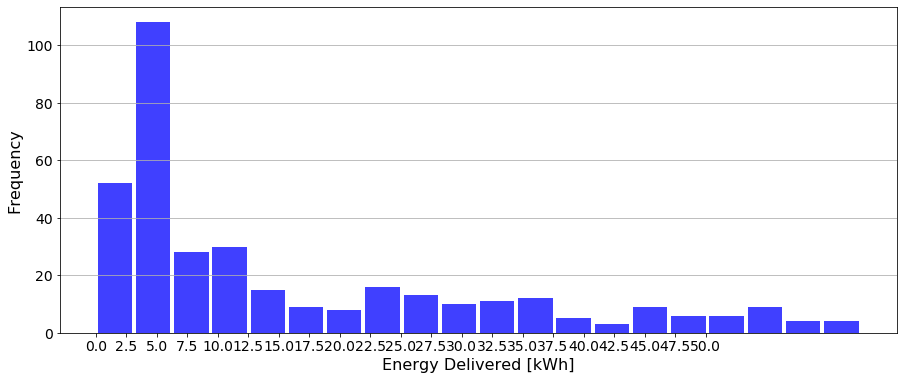

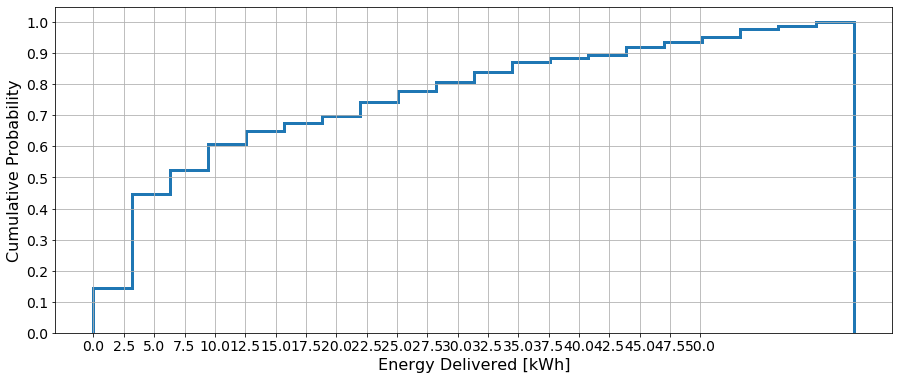

In [12]:
# Plot statistics on energy delivered
kWhDelivered = session_df['cumEnergy'].values/1000
num_bins = 20

plt.figure(figsize=(15,6))
plt.hist(kWhDelivered, num_bins, facecolor='blue', alpha=0.75, rwidth=0.9)
plt.xticks(np.arange(0, 52.5, step = 2.5),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Energy Delivered [kWh]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(15,6))
plt.hist(kWhDelivered, num_bins, density=True, histtype='step', cumulative=True, linewidth=3)
plt.grid(True)
plt.xticks(np.arange(0, 52.5, step = 2.5),FontSize=14)
plt.yticks(np.arange(0,1.1, step=0.1),FontSize=14)
plt.xlabel('Energy Delivered [kWh]',FontSize=16)
plt.ylabel('Cumulative Probability',FontSize=16)
plt.show()


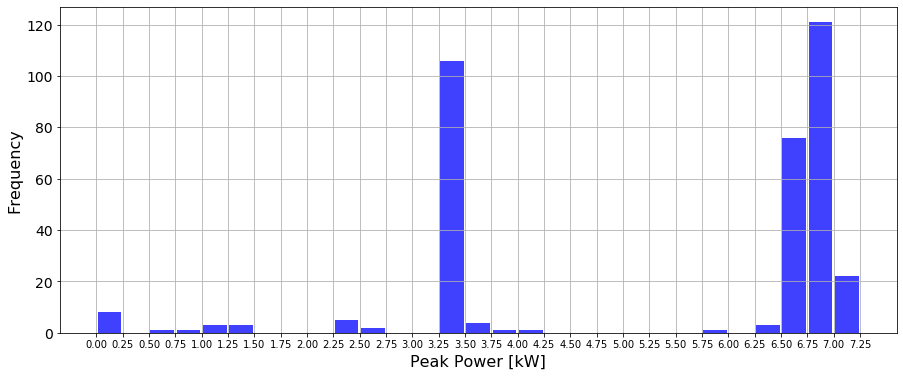

In [13]:
# Plot histogram of peak power
peakPower = session_df['peakPower'].values/1000
bins = np.arange(0, 7.5, step = 0.25)

plt.figure(figsize=(15,6))
plt.hist(peakPower, bins, facecolor='blue', alpha=0.75, rwidth=0.9)
plt.grid(True)
plt.xticks(bins,FontSize=10)
plt.yticks(FontSize=14)
plt.xlabel('Peak Power [kW]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.show()

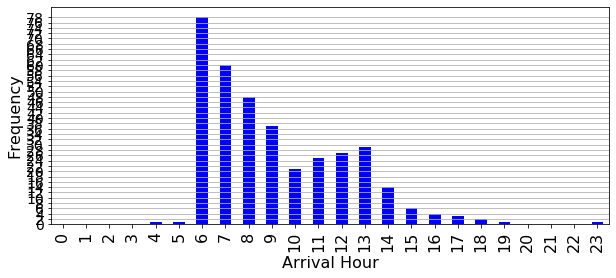

In [14]:
# Plot histogram of arrival times

arrival_df = session_df['connectTime'].astype('datetime64')

# Transform to a count
count = arrival_df.groupby(arrival_df.dt.hour).count()

# Re-create a new array of levels, now including all 24 hours
levels = np.arange(24)

# Reindex the count and fill empty values with zero (NaN by default)
count = count.reindex(levels, fill_value=0)
#print(count)

plt.figure(figsize=(10,4))
ax = count.plot(kind="bar", color='blue')

ax.set_xlabel('Arrival Hour',FontSize=16)
ax.set_ylabel('Frequency',FontSize=16)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0,max(count)+1, step=2),FontSize=14)
plt.grid(axis='y')

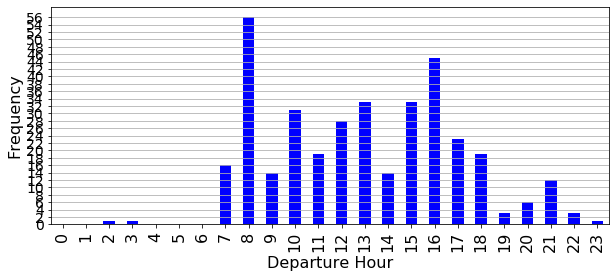

In [15]:
# Plot histogram of DEPARTURE times
departure_df = session_df['lastUpdate'].astype('datetime64')

# Transform to a count
count = departure_df.groupby(departure_df.dt.hour).count()

# Re-create a new array of levels, now including all 24 hours
levels = np.arange(24)

# Reindex the count and fill empty values with zero (NaN by default)
count = count.reindex(levels, fill_value=0)
#print(count)

plt.figure(figsize=(10,4))
ax = count.plot(kind="bar", color='blue')

ax.set_xlabel('Departure Hour',FontSize=16)
ax.set_ylabel('Frequency',FontSize=16)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0,max(count)+1, step=2),FontSize=14)
plt.grid(axis='y')

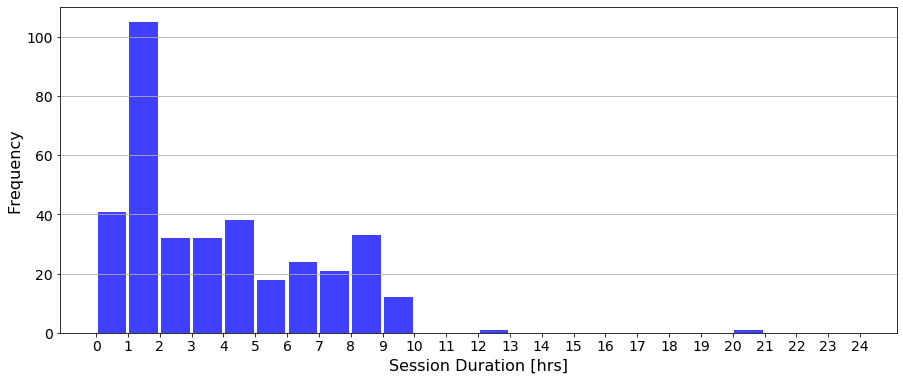

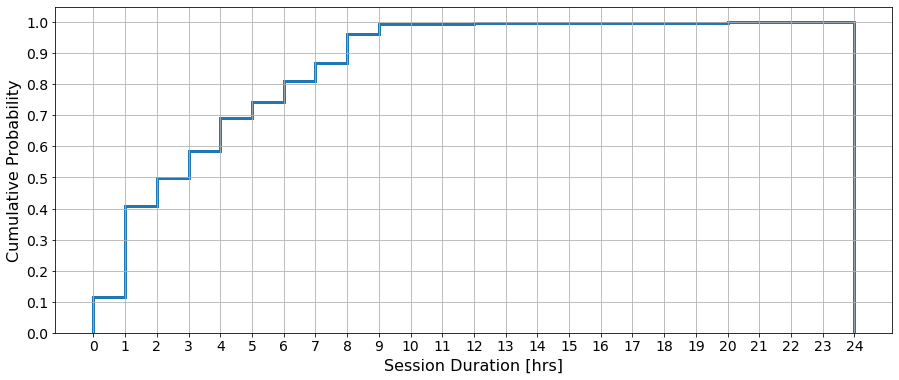

In [16]:
# Plot HISTOGRAM OF SESSION DURATION
duration = session_df['Duration'].dt.total_seconds()/3600
num_bins = np.arange(0, 25, step = 1)

plt.figure(figsize=(15,6))
plt.hist(duration, num_bins, facecolor='blue', alpha=0.75, rwidth=0.9)
plt.grid(axis='y')
plt.xticks(np.arange(0, 25, step = 1),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Session Duration [hrs]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.show()

plt.figure(figsize=(15,6))
plt.hist(duration, num_bins, density=True, histtype='step', cumulative=True, linewidth=3)
plt.grid(True)
plt.xticks(np.arange(0, 25, step = 1),FontSize=14)
plt.yticks(np.arange(0,1.1, step=0.1),FontSize=14)
plt.xlabel('Session Duration [hrs]',FontSize=16)
plt.ylabel('Cumulative Probability',FontSize=16)
plt.show()

In [17]:
# len(session_df)

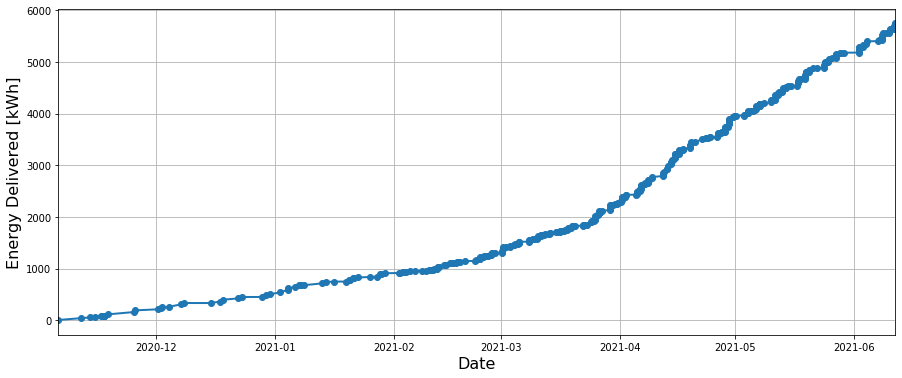

In [18]:
# Plot cumulative Energy Delivered
startTime = session_df['startChargeTime'].astype('datetime64').values
cumulativeEnergy = np.cumsum(session_df['cumEnergy'].values)/1000

plt.figure(figsize=(15,6))
plt.plot(startTime, cumulativeEnergy, LineWidth=2, marker='o')
plt.xlabel('Date',FontSize=16)
plt.ylabel('Energy Delivered [kWh]',FontSize=16)
plt.grid(True)
plt.xlim([min(startTime), max(startTime)]);

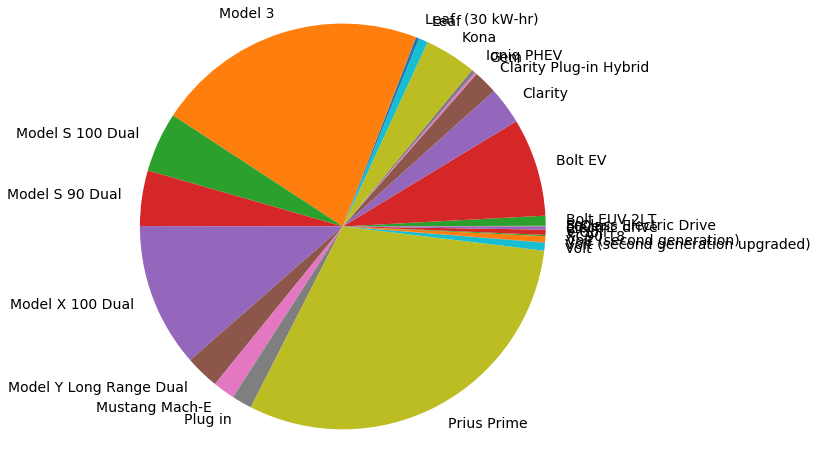

In [19]:
# Plot Breakdown of Vehicle Models
#df = pd.DataFrame({'Sex': ['female', 'male', 'female'], 'Smoke': [1, 3, 1]})

session_df.dcosId.groupby(session_df['vehicle_model']).sum().plot(kind='pie', radius=1.2, figsize=(8,8), fontsize=14)
plt.axis('equal')
plt.ylabel('')
plt.show()

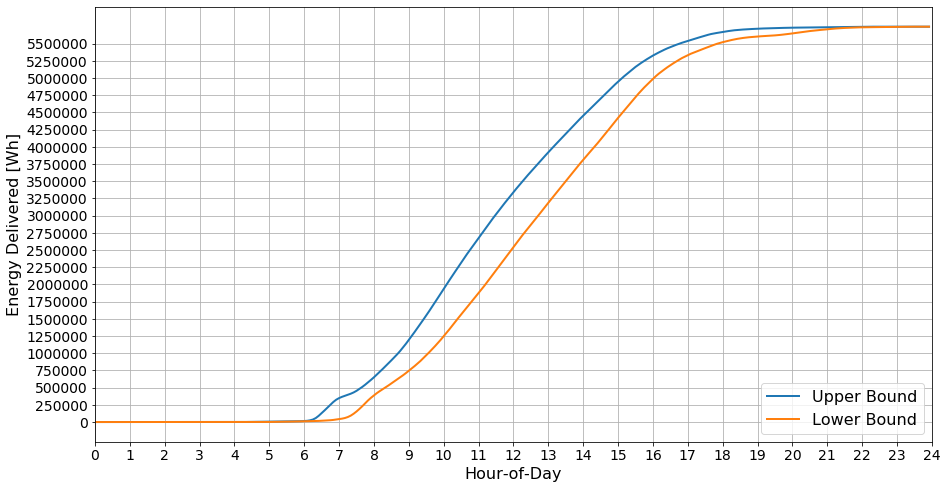

In [20]:
# COMPUTE THE ENERGY BOUNDS ASSUMING ALL HISTORICAL SESSIONS HAPPEN IN SAME 24 HOURS

# Create initial arrays of energy for upper- and lower-bounds
ub = np.zeros(24*12, dtype=int)
lb = np.zeros(24*12, dtype=int)

# Get arrival time, energyDelivered, and vehicle charging rate
arrivalTime_df = session_df['connectTime'].astype('datetime64')
departureTime_df = session_df['lastUpdate'].astype('datetime64')
WhDelivered_df = session_df['cumEnergy']
vehicle_maxChgRate_df = session_df['vehicle_maxChgRate']
evse_maxChgRate = 208*32

# Loop through each session and add energy
for idx in range(arrivalTime_df.shape[0]):
    
    # Floor arrival time to 5 minute interval
    aTime = arrivalTime_df[idx]
    aTime = aTime - timedelta(minutes=aTime.minute % 5,
                             seconds=aTime.second,
                             microseconds=aTime.microsecond)
    #print("Arrival Time:", aTime)
    
    # Floor departure time to 5 minute interval
    dTime = departureTime_df[idx]
    dTime = dTime - timedelta(minutes=dTime.minute % 5,
                             seconds=dTime.second,
                             microseconds=dTime.microsecond)
    #print("Departure Time:", dTime)
    
    # Get Watt-hour delivered for each session
    WhDelivered = WhDelivered_df[idx]
    #print("Wh delivered:", WhDelivered)
    
    # Get maximum AC charge rate in Watts, limited by EVSE or vehicle
    maxChgRate = int(min(vehicle_maxChgRate_df[idx], evse_maxChgRate))
    #print("max charge rate: ",maxChgRate)
    
    # Compute number of 5-minute time intervals to reach WhDelivered
    chargingIntervals = int(np.ceil(WhDelivered / maxChgRate * 12))
    #print("5-min charging intervals: ", chargingIntervals)


    
    # Create array of added cumulative energy delivered
    addedW = np.ones(chargingIntervals, dtype=int) * int(maxChgRate/12)
    addedWh = np.cumsum(addedW)

    
    
    # Now setup arrays within zero buffers at index of arrival time
    seconds_since_midnight_a = (aTime - aTime.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    minutes_since_midnight_a = seconds_since_midnight_a/60
    #print("min since midnight", minutes_since_midnight)
    five_min_index_a = int(minutes_since_midnight_a/5)
    #print("5-min index Arrival:", five_min_index_a)
    
    
    # Now setup arrays within zero buffers at index of departure time
    seconds_since_midnight_d = (dTime - dTime.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    minutes_since_midnight_d = seconds_since_midnight_d/60
    #print("min since midnight", minutes_since_midnight)
    five_min_index_d = int(minutes_since_midnight_d/5)
    #print("5-min index Departure:", five_min_index_d)
    
    
    
    
    # Check if session ends on same day. If not, then omit
    if(((five_min_index_a + chargingIntervals) <= (24*12)) & (chargingIntervals > 0) & (five_min_index_a <= five_min_index_d)):
    
        # zeros before
        zeros_before_a = np.zeros(five_min_index_a, dtype=int)
        zeros_before_d = np.zeros(five_min_index_d - chargingIntervals, dtype=int)

        # cumulative energy delivered after
        nonzeros_after_a = np.ones(24*12 - chargingIntervals - five_min_index_a, dtype=int)*addedWh[-1]
        nonzeros_after_d = np.ones(24*12 - five_min_index_d, dtype=int)*addedWh[-1]

        # concatenate zeros before and non-zeros after!
        addedWh_full_ub = np.concatenate( (zeros_before_a, addedWh, nonzeros_after_a), axis=0)
        addedWh_full_lb = np.concatenate( (zeros_before_d, addedWh, nonzeros_after_d), axis=0)
       
    else:
        addedWh_full_ub = np.zeros(24*12, dtype=int)
        addedWh_full_lb = np.zeros(24*12, dtype=int)

    #print(addedWh_full_ub)
    #print(addedWh_full_lb)
    #print(len(addedWh_full_lb))
    
    # Add to upper-bound
    ub = ub + addedWh_full_ub
    # Add to lower-bound
    lb = lb + addedWh_full_lb


# Plot UPPER AND LOWER BOUNDS
hour_array = np.arange(0,24,1/12)

plt.figure(figsize=(15,8))
plt.plot(hour_array, ub, LineWidth=2, label='Upper Bound')
plt.plot(hour_array, lb, LineWidth=2, label='Lower Bound')
plt.xticks(np.arange(0, 25, step = 1),FontSize=14)
plt.yticks(np.arange(0,ub[-1], step=250e3),FontSize=14)
plt.xlim([0, 24])
plt.xlabel('Hour-of-Day',FontSize=16)
plt.ylabel('Energy Delivered [Wh]',FontSize=16)
plt.legend(loc='lower right', prop={'size': 16})
plt.grid(True)

101.82890855457227
71.45427728613569


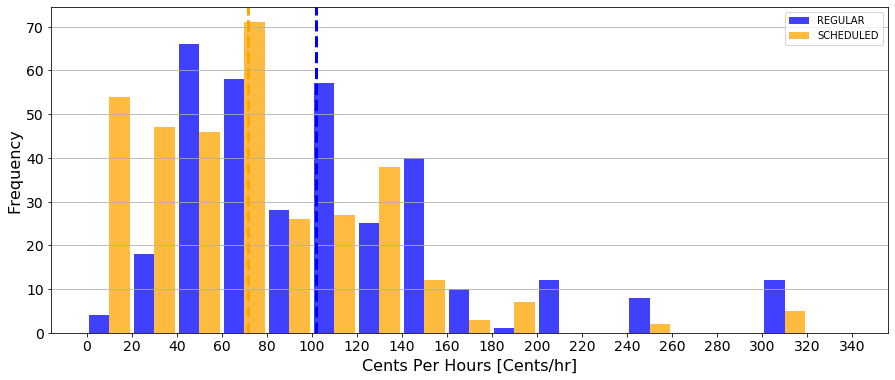

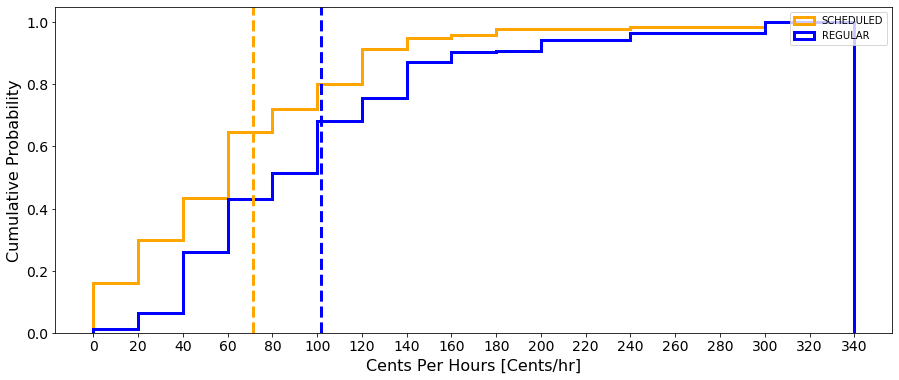

/Users/germa/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


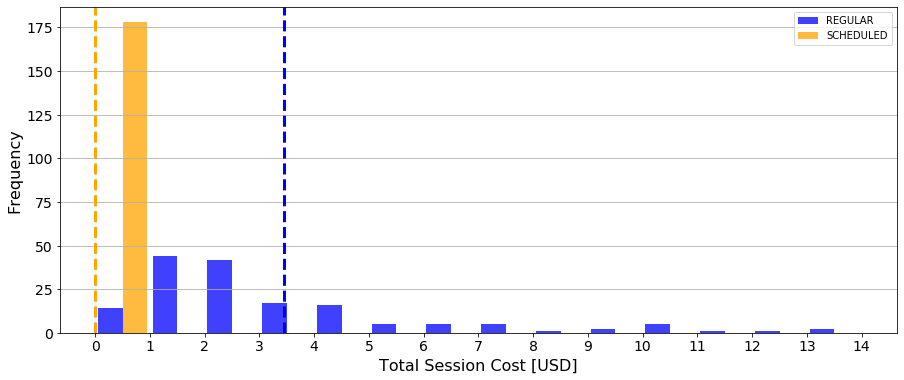

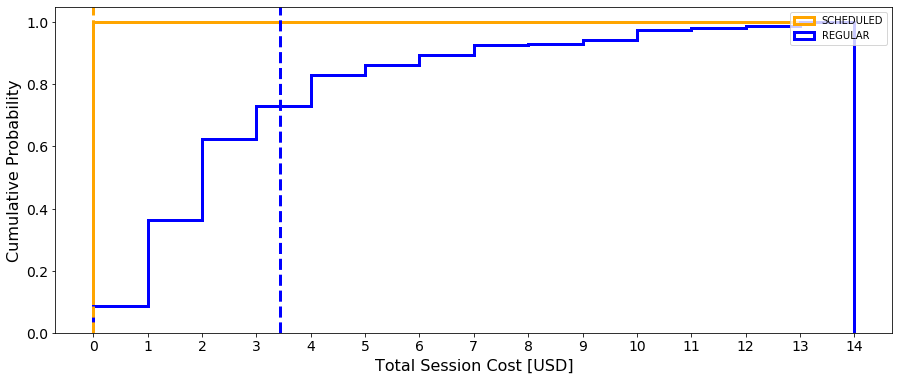

In [21]:
# Plot HISTOGRAM OF PRICES PER HOUR
reg_centsPerHr = session_df['reg_centsPerHr']
sch_centsPerHr = session_df['sch_centsPerHr']
num_bins = np.arange(0, 350, step = 20)

reg_mean = np.mean(reg_centsPerHr)
sch_mean = np.mean(sch_centsPerHr)
print(reg_mean)
print(sch_mean)

plt.figure(figsize=(15,6))
plt.hist([reg_centsPerHr, sch_centsPerHr], num_bins, color=['blue','orange'], alpha=0.75, rwidth=0.9, label=['REGULAR','SCHEDULED'])
plt.axvline(reg_centsPerHr.mean(), color='blue', linestyle='dashed', linewidth=3)
plt.axvline(sch_centsPerHr.mean(), color='orange', linestyle='dashed', linewidth=3)
plt.xticks(np.arange(0, 350, step = 20),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Cents Per Hours [Cents/hr]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()



# PLOT CDF of PRICES PER HOUR
plt.figure(figsize=(15,6))
plt.hist([reg_centsPerHr, sch_centsPerHr], num_bins, density=True, histtype='step', cumulative=True, linewidth=3, color=['blue','orange'], label=['REGULAR','SCHEDULED'])
plt.axvline(reg_centsPerHr.mean(), color='blue', linestyle='dashed', linewidth=3)
plt.axvline(sch_centsPerHr.mean(), color='orange', linestyle='dashed', linewidth=3)
plt.xticks(np.arange(0, 350, step = 20),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Cents Per Hours [Cents/hr]',FontSize=16)
plt.ylabel('Cumulative Probability',FontSize=16)
plt.legend(loc='upper right')
plt.show()



# Plot HISTOGRAM of TOTAL Session Costs
reg_totalcost = session_df[session_df['choice']=='REGULAR']['estCost']
sch_totalcost = session_df[session_df['choice']=='SCHEDULED']['estCost']
#sch_totalcost = sch_totalcost[sch_totalcost <= 10] # Remove SCHEDULED session with more than 15 USD
num_bins = np.arange(0, 15, step = 1)

reg_mean = np.mean(reg_totalcost)
sch_mean = np.mean(sch_totalcost)
#print(reg_totalcost)
#print(sch_mean)

plt.figure(figsize=(15,6))
plt.hist([reg_totalcost, sch_totalcost], num_bins, color=['blue','orange'], alpha=0.75, rwidth=0.9, label=['REGULAR','SCHEDULED'])
plt.axvline(reg_totalcost.mean(), color='blue', linestyle='dashed', linewidth=3)
plt.axvline(sch_totalcost.mean(), color='orange', linestyle='dashed', linewidth=3)
plt.xticks(num_bins,FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Total Session Cost [USD]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()

# Plot CDF of Total Session Costs
plt.figure(figsize=(15,6))
plt.hist([reg_totalcost, sch_totalcost], num_bins, density=True, histtype='step', cumulative=True, linewidth=3, color=['blue','orange'], label=['REGULAR','SCHEDULED'])
plt.axvline(reg_totalcost.mean(), color='blue', linestyle='dashed', linewidth=3)
plt.axvline(sch_totalcost.mean(), color='orange', linestyle='dashed', linewidth=3)
plt.xticks(num_bins,FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Total Session Cost [USD]',FontSize=16)
plt.ylabel('Cumulative Probability',FontSize=16)
plt.legend(loc='upper right')
plt.show()


In [22]:
# Loop through engineRecords to process data

sessions = []
choice_dict = {}
# csv file used
filename="EngineRecords.csv"

# opening the engineRecords CSV using "with" statement 
with open(filename,'r') as engineRecords: 
    
    # Loop through each record
    for record in csv.DictReader(engineRecords): 
        
        # Print key outputs from each record
        print(datetime.fromtimestamp(int(record['recordTimestamp (N)'])))
        print('--------------------------')
        print('nActive :', record['nActive (N)'], ' | siteId :', record['siteId (N)'])
        #print(record['sessions (L)'])
        #print(type(record['sessions (L)']))
        sessions_list = json.loads(record['sessions (L)'])
        #print(sessions)
        #print(type(sessions))
        
        # Loop through each session in each engineRecord
        for ses in sessions_list:
            
            sess = ses['M']
            
            # extract data
            dcosId = int(sess['session_dcosId']['N'])
            userId = int(sess['user_id']['N'])
            siteId = int(record['siteId (N)'])
            station_id = int(sess['station_id']['N'])
            
            connectionTime = datetime.fromtimestamp(int(sess['session_connectionTime']['N']))
            recordTimestamp = datetime.fromtimestamp(int(record['recordTimestamp (N)']))
            # Time since connection
            duration = (recordTimestamp - connectionTime)
            
            cumulativeEnergy = int(sess['reading_cumulativeEnergy']['N'])
            recentPower = int(sess['reading_avgPower']['N'])
            
            # print UserId, dcosId (sessionID), and station_id
            print('UserId : ', userId, '| dcosId : ', dcosId, '| station_id :', station_id)
            
            # print session duration, cumulative energy, instantaneous power
            print('Session Duration [min]: ', duration)
            print('reading_cumalativeEnergy [kWh] : ', cumulativeEnergy/1e3, '| reading_avgPower [kW] : ', recentPower/1e3)
            
            # print session choice parameters
            choice = sess['session_choice']['S']
            if choice == "REGULAR":
                print(choice, '| centsPerSessionHour: ', sess['session_centsPerSessionHour']['N'])
                choice_dict = {'choice':choice, 
                               'centsPerSessionHour':int(sess['session_centsPerSessionHour']['N'])}
            elif choice == "SCHEDULED":
                print(choice, '| centsPerSessionHour: ', sess['session_centsPerSessionHour']['N'], '| centsPerKwh:', sess['session_centsPerKwh']['N'], '| centsPerOverstayHour:', sess['session_centsPerOverstayHour']['N'])
                choice_dict = {'choice':choice, 
                               'centsPerSessionHour':int(sess['session_centsPerSessionHour']['N']),
                               'centsPerKwh':int(sess['session_centsPerKwh']['N']),
                               'centsPerOverstayHour':int(sess['session_centsPerOverstayHour']['N'])}
                
            # Consolidate each session record into dictionary
            session_dict = {'dcosId':dcosId, 'userId':userId, 'siteId':siteId, 'station_id':station_id,
                            'connectionTime': connectionTime.strftime("%m/%d/%Y, %H:%M:%S"), 
                            'duration':str(duration), 
                            'lastUpdate':recordTimestamp.strftime("%m/%d/%Y, %H:%M:%S"),
                            'cumulativeEnergy':cumulativeEnergy}
            session_dict.update(choice_dict)
            #print(session_dict)
            
            # If sessions list is empty, then just add current dictionary as first session
            if not sessions:
                sessions = [session_dict]
            # If sessions list is NOT empty, then loop through sessions list to find existing dcosId
            else:
                #print('update the list!')
                sessions_updated = 0
                for s in sessions:
                    if s['dcosId'] == dcosId:
                        s.update(session_dict)
                        sessions_updated = 1

                if not sessions_updated:
                    sessions.append(session_dict)
               
            #print(sessions)
            
            print('')
            
        print('')
        

2020-08-02 13:10:31
--------------------------
nActive : 9  | siteId : 1
UserId :  58285 | dcosId :  31 | station_id : 8
Session Duration [min]:  0:00:00
reading_cumalativeEnergy [kWh] :  0.033 | reading_avgPower [kW] :  0.001


2020-07-28 03:57:19
--------------------------
nActive : 8  | siteId : 2
UserId :  89729 | dcosId :  34 | station_id : 18
Session Duration [min]:  0:00:00
reading_cumalativeEnergy [kWh] :  0.041 | reading_avgPower [kW] :  0.002


2020-08-01 18:45:05
--------------------------
nActive : 0  | siteId : 2

2020-08-02 20:30:06
--------------------------
nActive : 0  | siteId : 2

2020-07-31 12:43:22
--------------------------
nActive : 9  | siteId : 2
UserId :  65516 | dcosId :  91 | station_id : 8
Session Duration [min]:  0:00:00
reading_cumalativeEnergy [kWh] :  0.042 | reading_avgPower [kW] :  0.006


2020-07-30 04:44:32
--------------------------
nActive : 3  | siteId : 1
UserId :  50719 | dcosId :  43 | station_id : 10
Session Duration [min]:  0:00:00
reading_c

UserId :  70930 | dcosId :  47 | station_id : 7
Session Duration [min]:  0:00:00
reading_cumalativeEnergy [kWh] :  0.061 | reading_avgPower [kW] :  0.004


2020-08-01 04:20:05
--------------------------
nActive : 0  | siteId : 2

2020-07-31 18:19:44
--------------------------
nActive : 4  | siteId : 3
UserId :  20390 | dcosId :  8 | station_id : 11
Session Duration [min]:  0:00:00
reading_cumalativeEnergy [kWh] :  0.06 | reading_avgPower [kW] :  0.004


2020-07-31 20:33:22
--------------------------
nActive : 7  | siteId : 2
UserId :  86873 | dcosId :  14 | station_id : 3
Session Duration [min]:  0:00:00
reading_cumalativeEnergy [kWh] :  0.016 | reading_avgPower [kW] :  0.005


2020-08-03 05:55:43
--------------------------
nActive : 4  | siteId : 2
UserId :  64125 | dcosId :  27 | station_id : 8
Session Duration [min]:  0:00:00
reading_cumalativeEnergy [kWh] :  0.095 | reading_avgPower [kW] :  0.005


2020-07-27 08:21:12
--------------------------
nActive : 9  | siteId : 1
UserId :  7

In [23]:
# Loop through each session list item

# for s in sessions:
    
#     # Query AWS DynamoDB for User info
#     table = dynamodb.Table('Users')
#     response = table.query(
#         KeyConditionExpression=Key('user_id').eq(s['userId'])
#     )
#     #print(response)
    
#     # Add user info to sessions list
#     user_dict = {'user_email':response['Items'][0]['user_email'],
#                  'vehicle_make':response['Items'][0]['vehicle_make'],
#                  'vehicle_model':response['Items'][0]['vehicle_model'],
#                  'vehicle_year':int(response['Items'][0]['vehicle_year'])}
#     s.update(user_dict)
    
#     # Print Results
#     print('------------------------')
#     print('dcosId         : ',s['dcosId'])
#     print('siteId         : ',s['siteId'])
#     print('')
#     print('userId         : ',s['userId'])
#     print('user_email     : ',s['user_email'])
#     print('vehicle_make   : ',s['vehicle_make'])
#     print('vehicle_model  : ',s['vehicle_model'])
#     print('vehicle_year   : ',s['vehicle_year'])
#     print('')
#     print('station_id     : ',s['station_id'])
#     print('connectionTime : ',s['connectionTime'])
#     print('duration       : ',s['duration'])
#     print('cumulativeEnergy [kWh] : ',s['cumulativeEnergy']/1e3)
#     print('Choice               : ',s['choice'])
#     if s['choice'] == 'REGULAR':
#         print('centsPerSessionHour  : ',s['centsPerSessionHour'])
#     elif s['choice'] == 'SCHEDULED':
#         print('centsPerSessionHour  : ',s['centsPerSessionHour'])
#         print('centsPerKwh          : ',s['centsPerKwh'])
#         print('centsPerOverstayHour : ',s['centsPerOverstayHour'])
        
#     print('')



## Section 2 

In [24]:
## Avoid changes to the sessions data by creating a copy 
session_df_Copy = session_df.copy()
session_df_Copy['departHour'] = session_df_Copy['lastUpdate'].astype('datetime64').dt.hour
session_df_Copy['arriHour'] = session_df_Copy['connectTime'].astype('datetime64').dt.hour




In [25]:
departure_hrs = departure_df.groupby(departure_df.dt.hour).count()
depart_by_hour = departure_hrs.reindex(levels, fill_value=0)
arrival_hrs = arrival_df.groupby(arrival_df.dt.hour).count()
arrival_by_hour = arrival_hrs.reindex(levels, fill_value=0)


In [26]:
# Total departures
total_de = depart_by_hour.values.sum()
total_ar = arrival_by_hour.values.sum()
# Probability of departures 
proba_depar = depart_by_hour.values/total_de
proba_arriv = arrival_by_hour.values/total_ar


In [27]:
# plt.plot(np.arange(24),proba_arriv)
# plt.xlabel('Arrival, time of day')
# plt.ylabel('Probability')

# Arrivals
ars = pd.DataFrame({'Day_hour':np.arange(24), 'arrivalFrequency':proba_arriv})

dep = pd.DataFrame({'Day_hour':np.arange(24), 'proba_depar':proba_arriv})


In [28]:
tim = pd.to_datetime(session_df_Copy['Duration'])
hours = tim.dt.hour + tim.dt.minute/60 + tim.dt.second/3600
session_df_Copy['hours'] = hours
session_df_Copy['cumEnergy_kWhr'] = session_df_Copy['cumEnergy']/1000
session_df_Copy

# This is the second way
session_df_Copy['averagePower'] = session_df_Copy['cumEnergy_kWhr']/session_df_Copy['hours']

real = session_df_Copy[['hours','averagePower','cumEnergy_kWhr','choice','peakPower','arriHour','departHour']]

len(real)

358

In [29]:
## Drop values that have 0 energy and where the arrival day is different from depart 
real = real[real['arriHour']<=real['departHour']]

real = real[real['cumEnergy_kWhr']!=0]


In [30]:
#arrival_by_hour = arrival_hrs.reindex(levels, fill_value=0)

prob_a = real.groupby('arriHour').count()['hours']
prob_ar = prob_a.reindex(levels, fill_value = 0)

prob_hap = prob_ar/prob_ar.values.sum()



[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.4257099] [loc=3.790 scale=2.805]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.3558923] [loc=0.013 scale=3.778]
[distfit] >[pareto    ] [0.07 sec] [RSS: 0.5620456] [loc=-1.403 scale=1.416]
[distfit] >[dweibull  ] [0.03 sec] [RSS: 0.4084302] [loc=3.928 scale=2.695]
[distfit] >[t         ] [0.25 sec] [RSS: 0.4257125] [loc=3.790 scale=2.805]
[distfit] >[genextreme] [0.23 sec] [RSS: 0.3521954] [loc=2.321 scale=2.009]
[distfit] >[gamma     ] [0.11 sec] [RSS: 0.3394408] [loc=-0.090 scale=2.682]
[distfit] >[lognorm   ] [0.22 sec] [RSS: 0.3435588] [loc=-1.322 scale=4.356]
[distfit] >[beta      ] [0.48 sec] [RSS: 0.3328475] [loc=0.013 scale=12.507]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.4804426] [loc=0.013 scale=12.279]
[distfit] >[loggamma  ] [0.36 sec] [RSS: 0.4265183] [loc=-806.242 scale=110.322]
[distfit] >Compute confidence interval [parametric]
[distfit] >Generate 2000 beta distributed samples with fitted 

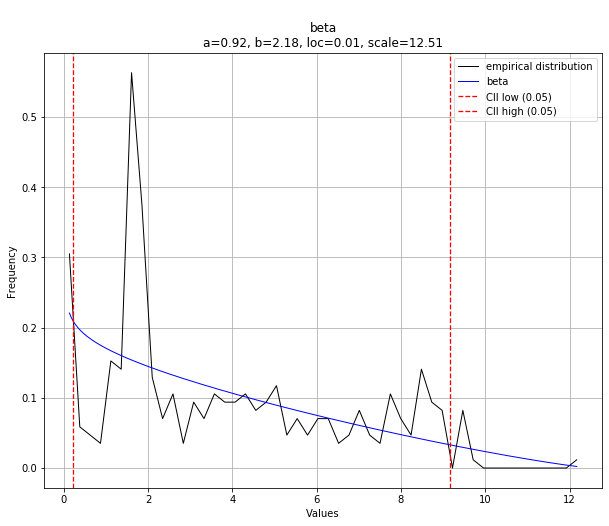

         distr     score  LLE        loc    scale  \
0         beta  0.332848  NaN  0.0127778  12.5071   
1        gamma  0.339441  NaN -0.0898044  2.68228   
2      lognorm  0.343559  NaN   -1.32172  4.35633   
3   genextreme  0.352195  NaN    2.32095  2.00905   
4        expon  0.355892  NaN  0.0127778   3.7776   
5     dweibull   0.40843  NaN    3.92778  2.69536   
6         norm   0.42571  NaN    3.79038  2.80451   
7            t  0.425713  NaN    3.79047  2.80456   
8     loggamma  0.426518  NaN   -806.242  110.322   
9      uniform  0.480443  NaN  0.0127778  12.2789   
10      pareto  0.562046  NaN   -1.40343  1.41621   

                                         arg  
0   (0.9176313465857109, 2.1828556284538685)  
1                      (1.4465939524293217,)  
2                      (0.5817771028999059,)  
3                    (-0.14906044547253977,)  
4                                         ()  
5                      (1.6694259815196928,)  
6                                 

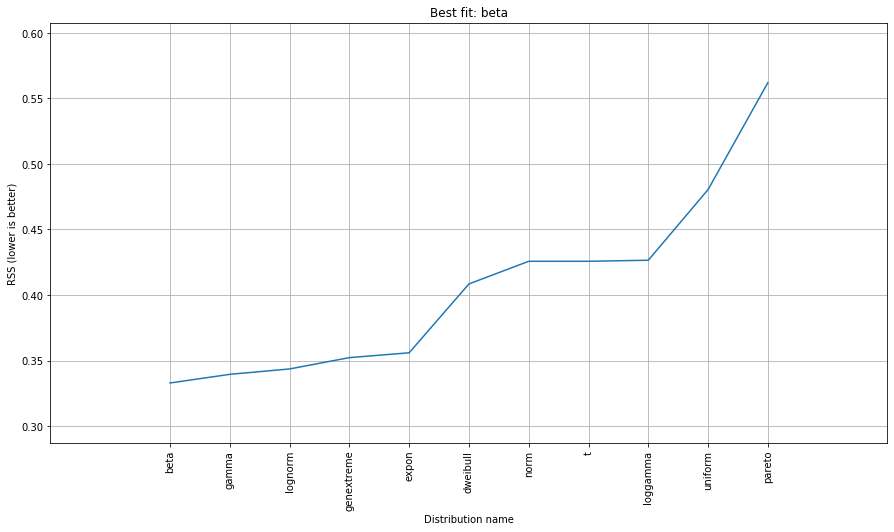

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff77764c9e8>)

In [31]:
from distfit import distfit
hours_dis = distfit(todf=True)
hours_dis.fit_transform(real['hours'])
Xgenerate = hours_dis.generate(n=2000)
hours_dis.plot()

print(hours_dis.summary)

# Distribution parameters for best fit
hours_dis.model

# Make plot
hours_dis.plot_summary()


In [32]:
# Generate non-uniform random samples based on giving probabilities 
day_hours = list(np.arange(24)) # 24 hours a day
ar = np.random.choice(day_hours, p=list(proba_arriv), size = 1000)
de = np.random.choice(day_hours, p=list(proba_depar), size = 1000)

# This is the second way 
#dur = gamma.rvs(1.66, -0.16, 2.15, size = 1000)

In [33]:
# Only choose the times where the departure is larger than arrival,

sess = [[arrive,depart] for arrive,depart in zip(ar,de) if arrive<=depart]
ar2 = np.random.choice(day_hours, p=list(prob_hap), size = 2000)
depar2 = [np.random.choice(real['hours']) for i in np.arange(len(ar2))]
# This is for the second strategy to match arrival and departure, we need to make sure 
sess2 = [[arrive,arrive+dur] for arrive,dur in zip(ar2,depar2) if (((arrive+dur)<=24)&((arrive+dur>=arrive)))]

# We know separate the arrvial and departures times,choose specific values 
sess2 = list(np.random.choice(pd.Series(sess2),size=1536))


a = [sess2[i][0] for i in np.arange(len(sess2))]
d2 = [sess2[i][1] for i in np.arange(len(sess2))]
# Obtain the departure as integer values
d = [int(sess2[i][1]) for i in np.arange(len(sess2))]


In [34]:
# Add a random value to the departure

arrivals = [sess[i][0] for i in np.arange(len(sess))]
departures = [sess[i][1] for i in np.arange(len(sess))]
departures_noise = [sess[i][1]+np.random.random() for i in np.arange(len(sess))]



In [35]:
generated = pd.DataFrame({'Arrivals':arrivals, 'Departures': departures, 'Departures_Noise': departures_noise})

generated2 = pd.DataFrame({'Arrivals':a, 'Departures_whole': d,'Departures':d2})



In [36]:
#session_df_Copy[['cumEnergy','arriHour','departHour']]

# The time difference between connect time and last update 

time_diff = pd.to_datetime(session_df_Copy['lastUpdate']) - pd.to_datetime(session_df_Copy['connectTime'])


Text(0, 0.5, 'Energy, kWhr')

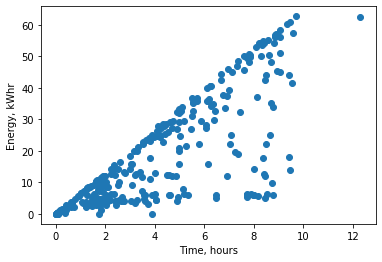

In [37]:
# Assuming this is W*hr 

# The reason why we see 2 slight differences is because of the 

# Capacity charging power for each vehicle: Most common are 3.3kW and 6.6kW 

# Drop rows that have have 0 energy 
gro = real[real['cumEnergy_kWhr']!=0]
plt.scatter(real['hours'], real['cumEnergy_kWhr'])
plt.xlabel('Time, hours')
plt.ylabel('Energy, kWhr')


In [38]:
from sklearn.metrics import mean_absolute_error as mae


# Drop rows that have have 0 energy 
# Least squares polynomial fit 


energy_fit = np.polyfit(real['hours'], real['cumEnergy_kWhr'], 1)
energy_fit


array([ 4.61000848, -1.15012519])

Text(4, 7, 'Energy=-1.15+4.61*hours')

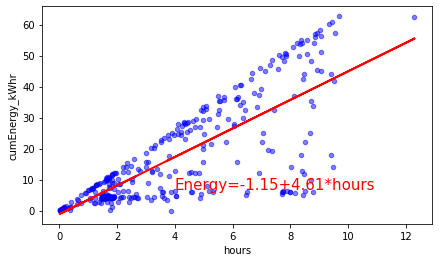

In [39]:
ax1 = real.plot(kind='scatter', x='hours', y='cumEnergy_kWhr', color='blue', alpha=0.5, figsize=(7, 4))

# Plotting fitting 

plt.plot(real['hours'], energy_fit[0] * real['hours'] + energy_fit[1], color='red', linewidth=2)

plt.text(4, 7, 'Energy={:.2f}+{:.2f}*hours'.format(energy_fit[1], energy_fit[0]), color='red', size=15)

#print('RMSE',np.sqrt(np.mean((real['cumEnergy_kWhr']-real['syn_Energy'])**2)))
#print('MAE',mae(real['cumEnergy_kWhr'],real['syn_Energy']))


In [40]:
# fit = [energy_fit[0]*hour + energy_fit[1] for hour in real['hours']] 
# plt.scatter(real['hours'],fit)



Text(0.5, 1.0, 'Polynmomial Line with White Noise')

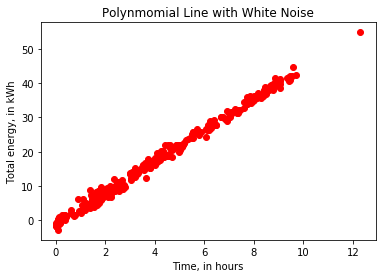

In [41]:
# Adding white noise to the polynomial line 

fit2 = [energy_fit[0]*hour + energy_fit[1] for hour in real['hours']] + np.random.normal(0,1,len(real))
plt.scatter(real['hours'],fit2, color='Red')
plt.xlabel('Time, in hours')
plt.ylabel('Total energy, in kWh')
plt.title('Polynmomial Line with White Noise')


In [42]:
generated['Duration'] = generated['Departures'] - generated['Arrivals']

# Using coefficients from real data to generate synthetic values 

#generated['Energy_kWhr'] = [energy_fit[0]*hour + energy_fit[1] for hour in generated['Duration']] + np.random.normal(0,1,len(generated))


Text(0.5, 1.0, 'Generated')

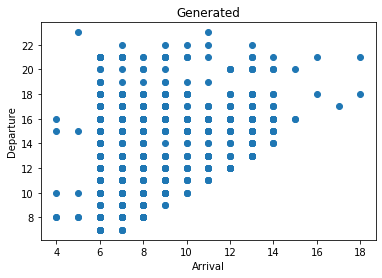

In [43]:
plt.scatter(generated['Arrivals'], generated['Departures'])
plt.xlabel('Arrival')
plt.ylabel('Departure')
plt.title('Generated')



Text(0, 0.5, 'Departure')

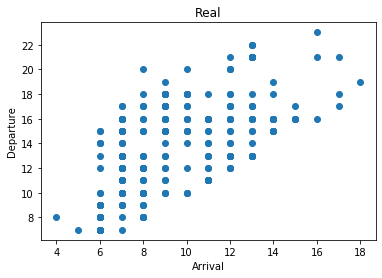

In [44]:
plt.scatter(real['arriHour'], real['departHour'])
plt.title('Real')
plt.xlabel('Arrival')
plt.ylabel('Departure')


In [45]:
#generated['Energy_kWhr'].median()/generated['Duration'].median()


In [46]:
real['syn_Energy'] = fit2
real.head()

,hours,averagePower,cumEnergy_kWhr,choice,peakPower,arriHour,departHour,syn_Energy
0,3.732500,0.879035,3.281,REGULAR,6335,10,14,17.752704
1,6.835278,4.894900,33.458,REGULAR,7005,7,14,29.622237
4,3.212500,3.886070,12.484,REGULAR,6852,11,14,12.554379
5,0.046944,2.300592,0.108,REGULAR,0,8,8,-1.813657
6,0.021111,1.847368,0.039,REGULAR,2659,8,8,-1.597617


In [47]:
# plt.scatter(real['hours'], real['syn_Energy'])
# plt.scatter(real['hours'], real['cumEnergy_kWhr'])

In [48]:
import numpy as np
import seaborn as sns

In [49]:
# Create a DataFrame that has 5 columns 
# Actual Arrival, Actual Departure, Default Departure, Actual Energy, Default Energy 
real['peakPower'] = real['peakPower']/1000

In [50]:
# Make default power delivered 

def kW_demand(df, str):
    """df: dataframe 
       str: column of appropiate charging"""
    holder = []
    for demand in df[str]:
        if demand>=4.5:
            holder.append(6.656) #in kW, max power 208*32/1000 
        elif 0 < demand and demand<4.5:
            holder.append(3.3)
        else:
            holder.append(0)
            
    return holder



In [51]:
real['cate_Power'] = kW_demand(real,'peakPower')



RMSE 9.83975211049392
MAE 5.559605411463335


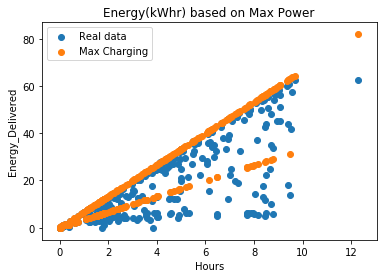

In [52]:
real['cate_Energy'] = real['hours']*real['cate_Power'] 

# Add white noise, because of the possibility of negative values (take abs)

real['cate_Energy_noise'] = abs(real['cate_Energy'] + np.random.normal(0,1,len(real)))

plt.scatter(real['hours'],real['cumEnergy_kWhr'])
plt.scatter(real['hours'],real['cate_Energy'])
plt.xlabel('Hours')
plt.legend(['Real data','Max Charging'])
plt.xlabel('Hours')
plt.ylabel('Energy_Delivered')
plt.title('Energy(kWhr) based on Max Power')
# RMSE 
print('RMSE',np.sqrt(np.mean((real['cumEnergy_kWhr']-real['cate_Energy'])**2)))
print('MAE',mae(real['cumEnergy_kWhr'],real['cate_Energy']))


Text(0.5, 1.0, 'Arrival during the day')

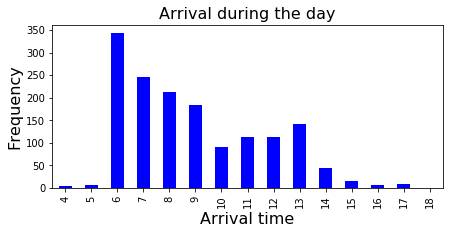

In [53]:
#grouping = generated.groupby('Arrivals').count()['Departures']

g2 = generated2.groupby('Arrivals').count()['Departures_whole']

plt.figure(figsize=(7,3))
ax = g2.plot(kind="bar", color='blue')

ax.set_xlabel('Arrival time',FontSize=16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Arrival during the day', fontsize = 16)

Text(0.5, 1.0, 'Departure during the day')

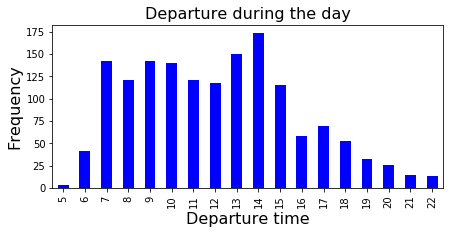

In [54]:
group2 = generated2.groupby('Departures_whole').count()['Arrivals']
plt.figure(figsize=(7,3))
ax = group2.plot(kind="bar", color='blue')

ax.set_xlabel('Departure time',FontSize=16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Departure during the day', fontsize = 16)


In [55]:
# Sort values by Arrivals and Departures
generated = generated.sort_values(by = ['Arrivals','Departures']).reset_index(drop=True)


In [56]:
# By hour of day

cumulative = generated.groupby('Arrivals').sum()


In [57]:
# Filtering out some data 
# upper = session_df_Copy['averagePower']>1 
# new = session_df_Copy[upper]


In [58]:
syn = generated['Duration']


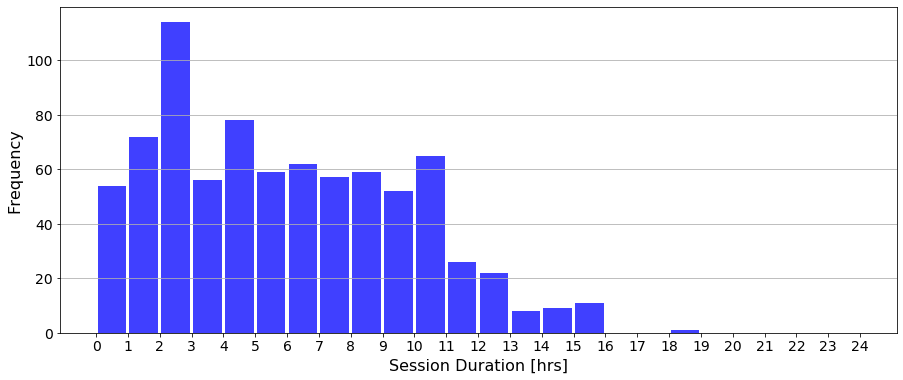

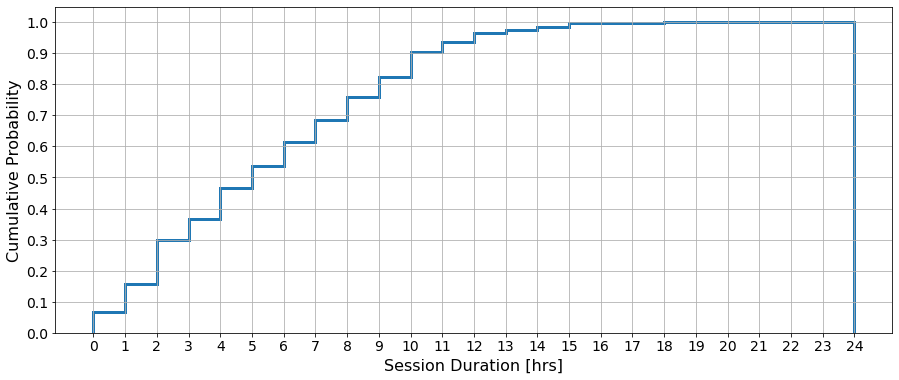

In [59]:
num_bins = np.arange(0, 25, step = 1)

plt.figure(figsize=(15,6))
plt.hist(syn, num_bins, facecolor='blue', alpha=0.75, rwidth=0.9)
plt.grid(axis='y')
plt.xticks(np.arange(0, 25, step = 1),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Session Duration [hrs]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.show()

plt.figure(figsize=(15,6))
plt.hist(syn, num_bins, density=True, histtype='step', cumulative=True, linewidth=3)
plt.grid(True)
plt.xticks(np.arange(0, 25, step = 1),FontSize=14)
plt.yticks(np.arange(0,1.1, step=0.1),FontSize=14)
plt.xlabel('Session Duration [hrs]',FontSize=16)
plt.ylabel('Cumulative Probability',FontSize=16)
plt.show()



In [60]:
piv = session_df_Copy[['arriHour','departHour']]
piv.head()


,arriHour,departHour
0,10,14
1,7,14
2,16,13
3,23,2
4,11,14


In [61]:
cou = piv.groupby(['arriHour','departHour']).size().reset_index().rename(columns={0:'Count'})
#cou.reset_index(level = ['arriHour','departHour','count'], inplace = True)


In [62]:
#cou.pivot_table(cou,index = ['arriHour'], columns = 'departHour').fillna(0)

#cou_fix = pd.DataFrame({'arriHour':cou.arriHour.values, 'departHour':cou.departHour.values,'count':cou.Count.values}

In [63]:
#cou_fix = pd.DataFrame({'arriHour':cou.arriHour.values, 'departHour':cou.departHour.values,'count':cou.Count.values})



In [64]:
#
gen = generated.groupby(['Arrivals','Departures']).size().reset_index().rename(columns={0:'Count'})
ta = gen.pivot_table(gen,index = ['Arrivals'], columns = 'Departures').fillna(0)

gen['realData_Power'] = np.random.choice(real['averagePower'],size=len(gen))

gen2 = generated2.groupby(['Arrivals','Departures']).size().reset_index().rename(columns = {0:'Count'})

# The unique arrivals

agg_arr2 = gen2['Arrivals'].unique()

prob2 = [gen2[gen2['Arrivals']==count]['Count']/gen2[gen2['Arrivals']==count]['Count'].sum() for 
         count in agg_arr2]




In [65]:

# The unique arrivals

agg_arrivals = gen['Arrivals'].unique()
# Count 
# The probabilities based on each individual arrival time 

probabilities = [gen[gen['Arrivals']==count]['Count']/gen[gen['Arrivals']==count]['Count'].sum() for 
                 count in agg_arrivals]

day_hour = [gen[gen['Arrivals']==i]['Departures'] for i in agg_arrivals]


In [66]:
# How many of real data falls in kW? 
day_hour2 = [gen2[gen2['Arrivals']==i]['Departures'] for i in agg_arr2]

In [67]:
# Real Power 


In [68]:
# Default departures based on random choice on given probabilities 

defaults = [int(np.random.choice(day_hour[i],p=probabilities[i],size=1)) for i in np.arange(len(day_hour))]

# Default rate
default_rate = np.random.choice([3.3,6.656],p=[.60,.40],size=len(defaults))

# Let't add noise in order to be able to calculate the energy 

defaultDeparture_Noise = [i+np.random.random() for i in defaults]
extra = pd.DataFrame({'Arrivals': agg_arrivals,'departDefault': defaults, 'defaultRate':default_rate,'defaultDeparture_Noise': defaultDeparture_Noise})




In [69]:
# Defaults for generated data for second 
default2 = [int(np.random.choice(day_hour2[i],p=prob2[i],size=1)) for i in np.arange(len(day_hour2))]

default_rate2 = np.random.choice([3.3,6.656],p=[.37,.63],size=len(default2))


In [70]:
# The generated data, we will grab one point from each distribution 

generated_data = gen.set_index('Arrivals').join(extra.set_index('Arrivals'))

extra2 = pd.DataFrame({'Arrivals': agg_arr2, 'departDefault': default2})
real.head()

,hours,averagePower,cumEnergy_kWhr,choice,peakPower,arriHour,departHour,syn_Energy,cate_Power,cate_Energy,cate_Energy_noise
0,3.732500,0.879035,3.281,REGULAR,6.335,10,14,17.752704,6.656,24.843520,24.116683
1,6.835278,4.894900,33.458,REGULAR,7.005,7,14,29.622237,6.656,45.495609,45.119543
4,3.212500,3.886070,12.484,REGULAR,6.852,11,14,12.554379,6.656,21.382400,22.229295
5,0.046944,2.300592,0.108,REGULAR,0.000,8,8,-1.813657,0.000,0.000000,1.526624
6,0.021111,1.847368,0.039,REGULAR,2.659,8,8,-1.597617,3.300,0.069667,0.465184


In [71]:
# plt.scatter(real['hours'], real['cumEnergy_kWhr'])

## Assigned 60% for 3.3kW and 40% for 6.6kW
not_zero = real[real['cate_Power']!=0]
chose_3 = np.round(sum(not_zero['cate_Power']==3.3)/len(not_zero),2)
chose_6 = np.round(sum(not_zero['cate_Power']==6.656)/len(not_zero),2)
sum(not_zero['cate_Power']==6.656)/len(not_zero)



generated2['maxPower_assigned'] = np.random.choice([3.3,6.656],p=[chose_3,chose_6],size=len(generated2))



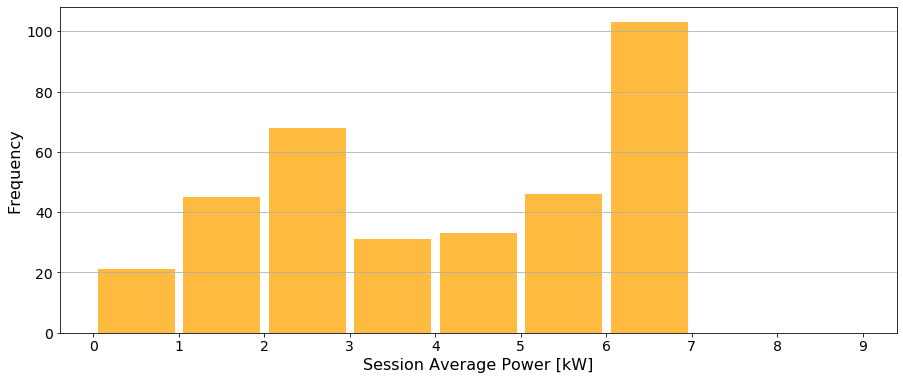

In [72]:
num_bins = np.arange(0, 10, step = 1)
plt.figure(figsize=(15,6))
plt.hist(real['averagePower'], num_bins, facecolor='Orange', alpha=0.75, rwidth=0.9)
plt.grid(axis='y')
plt.xticks(np.arange(0, 10, step = 1),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Session Average Power [kW]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.show()




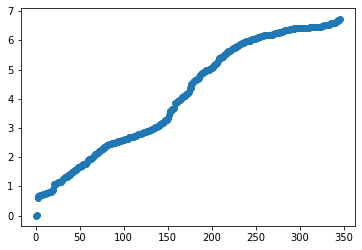

In [73]:
# Add another bucket for zero value 

le = real['averagePower']

# Why using Max Power might be a good 

plt.scatter(np.arange(len(le)), real['averagePower'].sort_values())



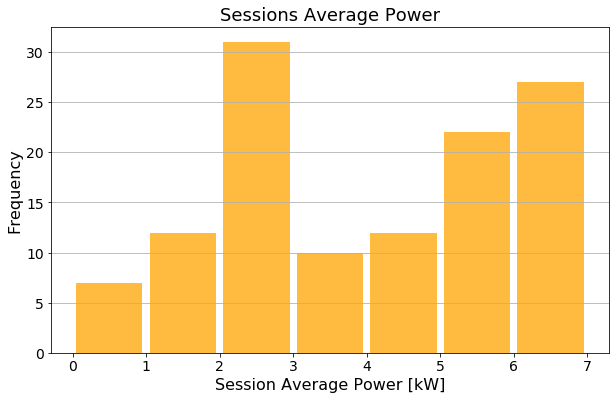

In [74]:
#np.random.choice(le)


num_bins = np.arange(0, 8, step = 1)
plt.figure(figsize=(10,6))
plt.hist(gen['realData_Power'], num_bins, facecolor='Orange', alpha=0.75, rwidth=0.9)
plt.grid(axis='y')
plt.xticks(np.arange(0, 8, step = 1),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Session Average Power [kW]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.title('Sessions Average Power', FontSize = 18)
plt.show()




In [75]:
#generated_data['energy_onReal'] = generated_data['defaultDeparture_Noise']*generated_data['realData_Power']


In [76]:
dur_hours = session_df_Copy['Duration'].dt.total_seconds()/3600

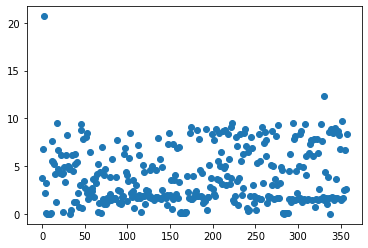

In [77]:
plt.scatter(np.arange(len(dur_hours)),dur_hours)


In [78]:
import warnings
import scipy.stats as st
import statsmodels as sm
# Drop the outlier


In [79]:
# best_fit_distribution(dur_hours)
from scipy.stats import exponnorm 
from scipy.stats import gamma
from scipy.stats import dweibull
from scipy.stats import loggamma

In [80]:
from distfit import distfit


In [81]:

# The parameters are obtained from empiral data 


In [82]:
# plt.figure(figsize=(15,6))
# plt.hist(gt, num_bins, facecolor='blue', alpha=0.75, rwidth=0.9)
# plt.hist(real['hours'], num_bins, facecolor='blue', alpha=0.75, rwidth=0.9)
# plt.grid(axis='y')
# plt.xticks(np.arange(0, 20, step = 1),FontSize=14)
# plt.yticks(FontSize=14)
# plt.xlabel('Session Duration [hrs]',FontSize=16)
# plt.ylabel('Frequency',FontSize=16)
# plt.show()


In [83]:
# Create a function that separates the 2. 
# We are looking at a Binomial distribution 

## There are 4 data sessions with 0 Power (drop these values)

power_true = real[real['cate_Power']!=0]
p1 = power_true[power_true['cate_Power']==3.3]


In [84]:
p1 = power_true[power_true['cate_Power']==3.3]
p2 = power_true[power_true['cate_Power']==6.656]




p1_dis = distfit(todf=True)
p1_dis.fit_transform(p1['averagePower'])



[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 2.5156044] [loc=2.053 scale=0.832]
[distfit] >[expon     ] [0.00 sec] [RSS: 4.5785262] [loc=0.003 scale=2.051]
[distfit] >[pareto    ] [0.22 sec] [RSS: 4.7178835] [loc=-56584379.644 scale=56584379.647]
[distfit] >[dweibull  ] [0.18 sec] [RSS: 2.0206831] [loc=2.059 scale=0.807]
[distfit] >[t         ] [0.45 sec] [RSS: 2.5155473] [loc=2.053 scale=0.832]
[distfit] >[genextreme] [0.25 sec] [RSS: 2.1554075] [loc=1.831 scale=0.885]
[distfit] >[gamma     ] [0.26 sec] [RSS: 2.5713768] [loc=-11.364 scale=0.053]
[distfit] >[lognorm   ] [0.38 sec] [RSS: 2.5260402] [loc=-174.707 scale=176.758]
[distfit] >[beta      ] [0.21 sec] [RSS: 2.1165245] [loc=-0.552 scale=4.289]
[distfit] >[uniform   ] [0.00 sec] [RSS: 2.9579942] [loc=0.003 scale=3.666]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 2.0835529] [loc=2.482 scale=0.668]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.dweibull_gen at 0x7ff776c58f28>,
  'stats': 'RSS',
  'params': (1.7520559036238685, 2.058543150357573, 0.8070386532180887),
  'name': 'dweibull',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7ff77985a7f0>,
  'score': 2.0206830910499707,
  'loc': 2.058543150357573,
  'scale': 0.8070386532180887,
  'arg': (1.7520559036238685,),
  'CII_min_alpha': 0.7594752437448291,
  'CII_max_alpha': 3.357611056970317},
 'summary':          distr    score  LLE          loc        scale  \
 0     dweibull  2.02068  NaN      2.05854     0.807039   
 1     loggamma  2.08355  NaN      2.48194     0.668453   
 2         beta  2.11652  NaN    -0.552425      4.28881   
 3   genextreme  2.15541  NaN      1.83081     0.884646   
 4            t  2.51555  NaN      2.05344     0.832077   
 5         norm   2.5156  NaN       2.0534     0.832074   
 6      lognorm  2.52604  NaN     -174.707      176.758   
 7        gamma  2.57138  NaN     -11.3636 

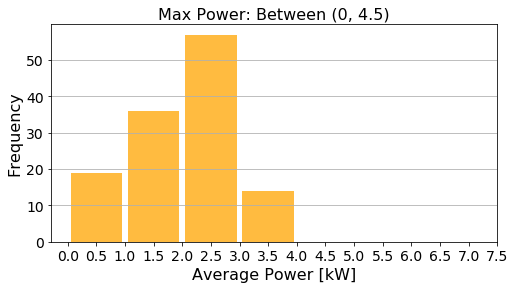

In [85]:
plt.figure(figsize=(8,4))
plt.hist(p1['averagePower'], num_bins, facecolor='orange', alpha=0.75, rwidth=0.9)
plt.grid(axis='y')
plt.xticks(np.arange(0, 8, step = .5),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Average Power [kW]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.title('Max Power: Between (0, 4.5)', FontSize = 16)
plt.show()



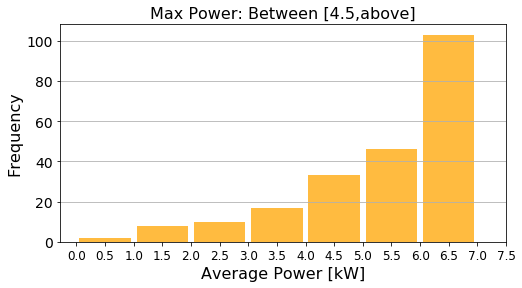

In [86]:
plt.figure(figsize=(8,4))
plt.hist(p2['averagePower'], np.arange(0, 8, step = 1), facecolor='Orange', alpha=0.75, rwidth=0.9)
plt.grid(axis='y')
plt.xticks(np.arange(0, 8, step = .5),FontSize=12)
plt.yticks(FontSize=14)
plt.xlabel('Average Power [kW]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.title('Max Power: Between [4.5,above]', FontSize = 16)
plt.show()


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 2.2576280] [loc=5.318 scale=1.394]
[distfit] >[expon     ] [0.00 sec] [RSS: 3.6009957] [loc=0.707 scale=4.610]
[distfit] >[pareto    ] [0.18 sec] [RSS: 3.7407656] [loc=-99126565.648 scale=99126566.355]
[distfit] >[dweibull  ] [0.19 sec] [RSS: 1.3975160] [loc=6.187 scale=1.067]
[distfit] >[t         ] [0.12 sec] [RSS: 1.8335694] [loc=5.829 scale=0.822]
[distfit] >[genextreme] [0.25 sec] [RSS: 1.1877106] [loc=5.298 scale=1.399]
[distfit] >[gamma     ] [0.18 sec] [RSS: 2.3270632] [loc=-19.279 scale=0.088]
[distfit] >[lognorm   ] [0.35 sec] [RSS: 2.2591648] [loc=-887.352 scale=892.670]
[distfit] >[beta      ] [0.10 sec] [RSS: 2.1411624] [loc=0.102 scale=6.641]
[distfit] >[uniform   ] [0.00 sec] [RSS: 2.7894787] [loc=0.707 scale=6.036]
[distfit] >[loggamma  ] [0.03 sec] [RSS: 0.9282102] [loc=6.678 scale=0.066]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


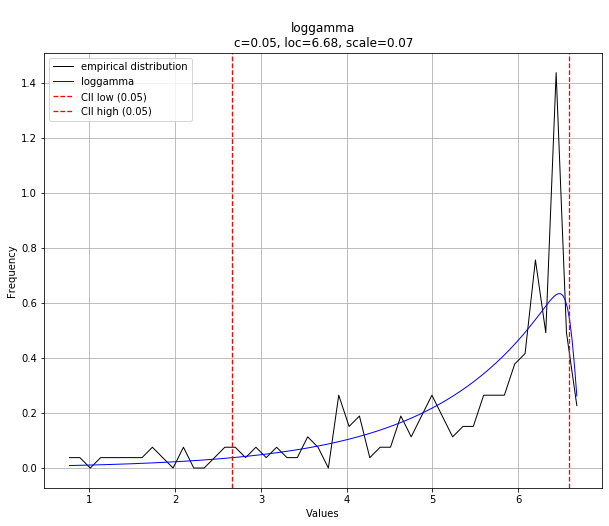

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff77994b160>)

In [87]:
p2_dis = distfit(todf=True)
p2_dis.fit_transform(p2['averagePower'])
p2_dis.plot()

         distr    score  LLE          loc        scale  \
0     loggamma  0.92821  NaN      6.67763    0.0658137   
1   genextreme  1.18771  NaN      5.29764      1.39903   
2     dweibull  1.39752  NaN      6.18684      1.06683   
3            t  1.83357  NaN      5.82889     0.822291   
4         beta  2.14116  NaN     0.102379      6.64117   
5         norm  2.25763  NaN      5.31784      1.39448   
6      lognorm  2.25916  NaN     -887.352       892.67   
7        gamma  2.32706  NaN     -19.2791    0.0881581   
8      uniform  2.78948  NaN     0.707436      6.03611   
9        expon    3.601  NaN     0.707436       4.6104   
10      pareto  3.74077  NaN -9.91266e+07  9.91266e+07   

                                         arg  
0                     (0.04959436142297664,)  
1                      (0.9674130139664657,)  
2                      (0.7753412952514651,)  
3                      (2.2401262914279387,)  
4   (1.8423167440767243, 0.4720941489408177)  
5                    

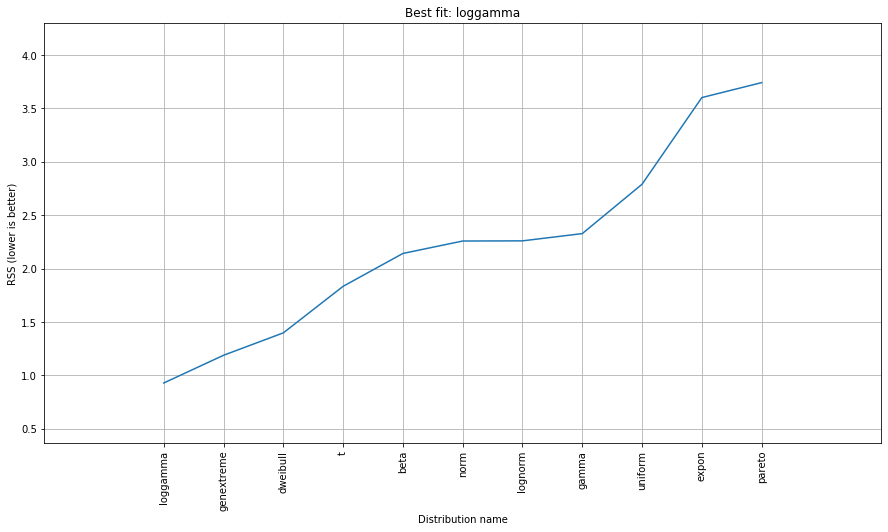

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff779c6f2b0>)

In [88]:
print(p2_dis.summary)

# Distribution parameters for best fit
p2_dis.model

# Make plot
p2_dis.plot_summary()



[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.4257099] [loc=3.790 scale=2.805]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.3558923] [loc=0.013 scale=3.778]
[distfit] >[pareto    ] [0.07 sec] [RSS: 0.5620456] [loc=-1.403 scale=1.416]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 0.4084302] [loc=3.928 scale=2.695]
[distfit] >[t         ] [0.21 sec] [RSS: 0.4257125] [loc=3.790 scale=2.805]
[distfit] >[genextreme] [0.11 sec] [RSS: 0.3521954] [loc=2.321 scale=2.009]
[distfit] >[gamma     ] [0.12 sec] [RSS: 0.3394408] [loc=-0.090 scale=2.682]
[distfit] >[lognorm   ] [0.14 sec] [RSS: 0.3435588] [loc=-1.322 scale=4.356]
[distfit] >[beta      ] [0.37 sec] [RSS: 0.3328475] [loc=0.013 scale=12.507]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.4804426] [loc=0.013 scale=12.279]
[distfit] >[loggamma  ] [0.27 sec] [RSS: 0.4265183] [loc=-806.242 scale=110.322]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


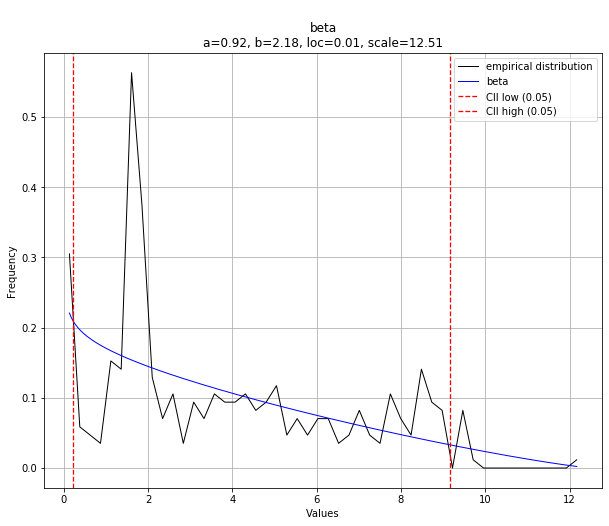

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff779b16710>)

In [89]:
# hous_dis = real['hours']
hours_dis = distfit(todf=True)
hours_dis.fit_transform(real['hours'])
hours_dis.plot()



         distr     score  LLE        loc    scale  \
0         beta  0.332848  NaN  0.0127778  12.5071   
1        gamma  0.339441  NaN -0.0898044  2.68228   
2      lognorm  0.343559  NaN   -1.32172  4.35633   
3   genextreme  0.352195  NaN    2.32095  2.00905   
4        expon  0.355892  NaN  0.0127778   3.7776   
5     dweibull   0.40843  NaN    3.92778  2.69536   
6         norm   0.42571  NaN    3.79038  2.80451   
7            t  0.425713  NaN    3.79047  2.80456   
8     loggamma  0.426518  NaN   -806.242  110.322   
9      uniform  0.480443  NaN  0.0127778  12.2789   
10      pareto  0.562046  NaN   -1.40343  1.41621   

                                         arg  
0   (0.9176313465857109, 2.1828556284538685)  
1                      (1.4465939524293217,)  
2                      (0.5817771028999059,)  
3                    (-0.14906044547253977,)  
4                                         ()  
5                      (1.6694259815196928,)  
6                                 

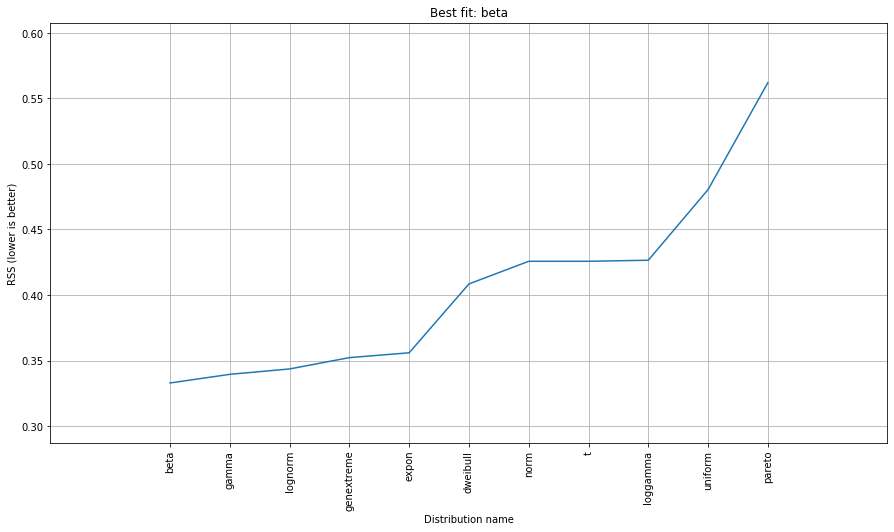

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7798ea8d0>)

In [90]:
print(hours_dis.summary)

# Distribution parameters for best fit
hours_dis.model

# Make plot
hours_dis.plot_summary()


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 1.1766226] [loc=4.112 scale=1.992]
[distfit] >[expon     ] [0.00 sec] [RSS: 1.4587304] [loc=0.003 scale=4.109]
[distfit] >[pareto    ] [0.22 sec] [RSS: 1.4405446] [loc=-109654250.702 scale=109654250.705]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 0.8784710] [loc=4.021 scale=2.024]
[distfit] >[t         ] [0.23 sec] [RSS: 1.1766068] [loc=4.112 scale=1.992]
[distfit] >[genextreme] [0.18 sec] [RSS: 0.8627484] [loc=3.996 scale=2.410]
[distfit] >[gamma     ] [0.20 sec] [RSS: 1.1771092] [loc=-34.069 scale=0.106]
[distfit] >[lognorm   ] [0.33 sec] [RSS: 1.1810216] [loc=-196.583 scale=200.678]
[distfit] >[beta      ] [0.19 sec] [RSS: 0.7786498] [loc=-0.100 scale=6.843]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.9846513] [loc=0.003 scale=6.741]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.7619784] [loc=6.693 scale=0.058]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


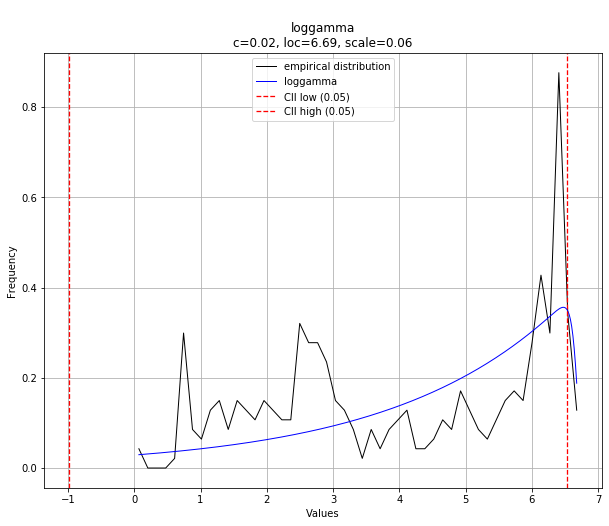

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7796c2240>)

In [91]:
al_po = distfit(todf=True)
al_po.fit_transform(real['averagePower'])
al_po.plot()

In [92]:
#XPower = al_po.generate(len(generated2))
p1_dis.generate(1)

[distfit] >Generate 1 dweibull distributed samples with fitted params (1.7520559036238685, 2.058543150357573, 0.8070386532180887).


array([2.59902391])

In [93]:

def chose(df,str):
    """df: dataframe"""
    helper= []
    for po in df[str]:
        if po==3.3:
            # helper.append(abs(float(dweibull.rvs(1.53,2.14,0.94, size=1))))
            helper.append(abs(float(dweibull.rvs(1.55,1.92,0.79, size=1))))
        else:
            #helper.append(abs(float(loggamma.rvs(0.18, 6.615, 0.111))))
            helper.append(abs(float(loggamma.rvs(0.196, 6.618, 0.12))))
    return helper



In [94]:
generated2['Power'] = chose(generated2,'maxPower_assigned')
generated2['Duration'] = generated2['Departures']-generated2['Arrivals']
generated2['Energy'] = generated2['Power']*generated2['Duration']



In [95]:
generated2['Energy'] = list(generated2['Power']*generated2['Duration'].values)

Text(0.5, 1.0, 'Real vs Generated energy')

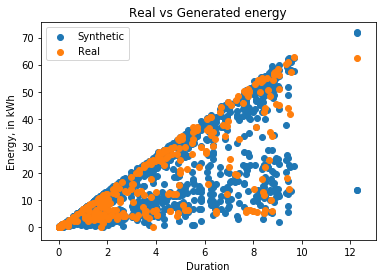

In [96]:
plt.scatter(generated2['Duration'],generated2['Energy'])
plt.scatter(real['hours'], real['cumEnergy_kWhr'])
plt.legend(['Synthetic','Real'])
plt.xlabel('Duration')
plt.ylabel('Energy, in kWh')
plt.title('Real vs Generated energy')

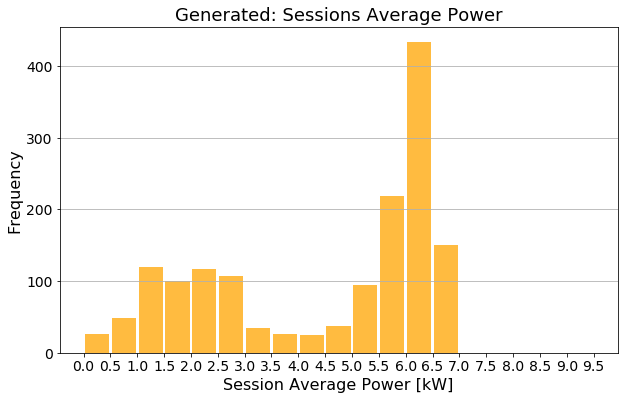

In [97]:
num_bins = np.arange(0, 10, step = .5)
plt.figure(figsize=(10,6))
plt.hist(generated2['Power'], num_bins, facecolor='Orange', alpha=0.75, rwidth=0.9)
plt.grid(axis='y')
plt.xticks(np.arange(0, 10, step = .5),FontSize=14)
plt.yticks(FontSize=14)
plt.xlabel('Session Average Power [kW]',FontSize=16)
plt.ylabel('Frequency',FontSize=16)
plt.title('Generated: Sessions Average Power', FontSize = 18)
plt.show()


In [98]:
generated2.describe()

,Arrivals,Departures_whole,Departures,maxPower_assigned,Power,Duration,Energy
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000
mean,8.925130,12.100260,12.599907,5.412794,4.483491,3.674777,16.402050
std,2.677739,3.732641,3.742649,1.621218,2.075713,2.740092,15.407459
min,4.000000,5.000000,5.119722,3.300000,0.057494,0.012778,0.004995
25%,7.000000,9.000000,9.507153,3.300000,2.405949,1.584306,4.869833
50%,8.000000,12.000000,12.492778,6.656000,5.628749,2.706944,10.737545
75%,11.000000,14.000000,14.987778,6.656000,6.258836,5.511389,23.584820
max,18.000000,22.000000,22.838611,6.656000,6.802337,12.291667,71.942514


In [99]:
#session_df_Copy['peakPower_kW'] = session_df_Copy['peakPower']/1000

In [100]:
selected = ['arriHour','departHour','hours','cumEnergy_kWhr','averagePower','peakPower_kW']
session_df_Copy['peakPower_kW'] = session_df_Copy['peakPower']/1000
session_df_Copy[selected].describe()


,arriHour,departHour,hours,cumEnergy_kWhr,averagePower,peakPower_kW
count,358.000000,358.000000,358.000000,358.00000,358.000000,358.000000
mean,9.159218,12.952514,3.837900,16.05452,4.023748,5.366193
std,3.022754,3.999367,2.945910,16.40653,2.071387,1.931118
min,4.000000,2.000000,0.012778,0.00000,0.000000,0.000000
25%,7.000000,10.000000,1.602500,4.24425,2.391972,3.390750
50%,8.000000,13.000000,3.022778,8.42600,4.105335,6.658000
75%,11.000000,16.000000,6.087639,25.89100,6.173845,6.846500
max,23.000000,23.000000,20.667222,62.70200,6.743546,7.163000


In [101]:
# session_df_Copy.head()


In [102]:
last = pd.to_datetime(session_df_Copy['lastUpdate'])
start = pd.to_datetime(session_df_Copy['startChargeTime'])


In [103]:
dura = (last-start).dt.seconds/3600
#session_df_Copy['Duration'].dt.seconds/3600 


In [104]:
# Convert the time into normal time 
def convert(seconds):
    tim = [time.strftime("%H:%M:%S", time.gmtime(int(second))) for second in seconds]
    return pd.to_datetime(tim)

In [105]:
generated2['Normal_arrivalTime'] = convert(generated2['Arrivals']*3600)

In [106]:
generated2['Normal_departureTime'] = convert(generated2['Departures']*3600)

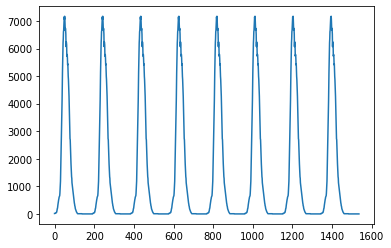

In [107]:
up = pd.read_csv('minute_demand_scenario.csv')['p_max']
lb = pd.read_csv('minute_demand_scenario.csv')['p_min']
plt.plot(np.arange(len(up)),up)

#pd.read_csv('minute_demand_scenario.csv')


In [108]:
from datetime import timedelta

pr = (generated2['Departures']-generated2['Departures_whole'])
pr2 = (generated2['Departures']-generated2['Departures_whole']).loc[1]


In [109]:
import math

In [110]:
# Round to nearest .25 minutes, this is equal to 15 min in an hour 

def custom_round(x, base=.25):
    return base * round(float(x)/base)

df = pr.apply(lambda x: custom_round(x, base=.25))
generated2['Quarter_rounding'] = generated2['Departures'].apply(lambda x: custom_round(x, base=.25))


In [111]:
# Convert this time interval into seconds, and then convert to normal time interval

#generated2['15minIntervalDeparture'] = convert(generated2['Quarter_rounding']*3600)


In [112]:
# Sort values by Arrival time 


In [113]:

generated2['15minTimestepDepart'] = [int(ti) for ti in generated2['Quarter_rounding']*60/15]
#generated2 = generated2.sort_values(by = ['Arrivals','Departures']).reset_index()

In [114]:
generated2['p_min'] = 0

In [115]:
e_ma = [max(generated2['maxPower_assigned'][i], generated2['Power'][i])*generated2['Duration'][i] for i in np.arange(len(generated2))]

e_mi = [min(generated2['maxPower_assigned'][i], generated2['Power'][i])*generated2['Duration'][i] for i in np.arange(len(generated2))]

p_max = [max(generated2['maxPower_assigned'][i], generated2['Power'][i]) for i in np.arange(len(generated2))]



In [116]:
generated2['e_max'] = e_ma
generated2['e_min'] = e_mi
generated2['p_max'] = p_max


In [117]:
gr = generated2.groupby('Arrivals').sum()
gr2 = gr.cumsum()



Text(0.5, 0, 'Day, in 15min interval')

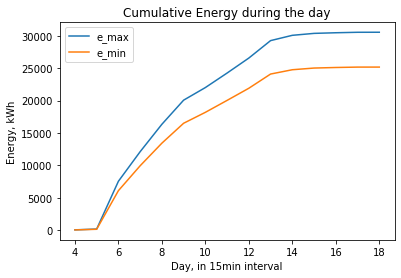

In [118]:
plt.plot(gr.index, gr2['e_max'])
plt.plot(gr.index, gr2['e_min'])
plt.legend(['e_max','e_min'])
plt.title('Cumulative Energy during the day')
plt.ylabel('Energy, kWh')
plt.xlabel('Day, in 15min interval')

In [119]:
generated2.head()

,Arrivals,Departures_whole,Departures,maxPower_assigned,Power,Duration,Energy,Normal_arrivalTime,Normal_departureTime,Quarter_rounding,15minTimestepDepart,p_min,e_max,e_min,p_max
0,9,15,15.098889,3.300,3.327812,6.098889,20.295957,2021-08-17 09:00:00,2021-08-17 15:05:56,15.00,60,0,20.295957,20.126333,3.327812
1,6,7,7.511389,6.656,5.719850,1.511389,8.644917,2021-08-17 06:00:00,2021-08-17 07:30:41,7.50,30,0,10.059804,8.644917,6.656000
2,13,14,14.531667,6.656,6.263761,1.531667,9.593993,2021-08-17 13:00:00,2021-08-17 14:31:54,14.50,58,0,10.194773,9.593993,6.656000
3,12,13,13.837500,3.300,3.021555,1.837500,5.552108,2021-08-17 12:00:00,2021-08-17 13:50:15,13.75,55,0,6.063750,5.552108,3.300000
4,8,15,15.833056,6.656,4.445958,7.833056,34.825435,2021-08-17 08:00:00,2021-08-17 15:49:59,15.75,63,0,52.136818,34.825435,6.656000


In [120]:
# Create the fifteen minute interval
upper_bound = np.zeros(24*4, dtype=int)
lower_bound = np.zeros(24*4, dtype=int)


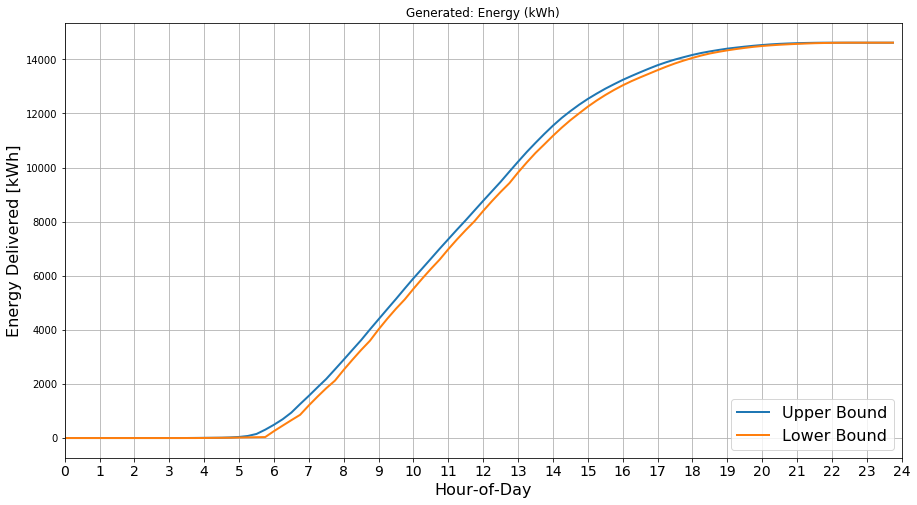

In [121]:
# Create initial arrays of energy for upper- and lower-bounds
ub = np.zeros(24*4, dtype=int)
lb = np.zeros(24*4, dtype=int)

# Get arrival time, energyDelivered, and vehicle charging rate
arrivalTime_df = generated2['Normal_arrivalTime'].astype('datetime64')
departureTime_df = generated2['Normal_departureTime'].astype('datetime64')
kWhDelivered_df = generated2['Energy']
vehicle_maxChgRate_df = generated2['Power']
evse_maxChgRate = generated2['maxPower_assigned']

# Loop through each session and add energy
for idx in range(arrivalTime_df.shape[0]):
    
    # Floor arrival time to 5 minute interval
    aTime = arrivalTime_df[idx]
    aTime = aTime - timedelta(minutes=aTime.minute % 15,
                             seconds=aTime.second,
                             microseconds=aTime.microsecond)
    #print("Arrival Time:", aTime)
    
    # Floor departure time to 5 minute interval
    dTime = departureTime_df[idx]
    dTime = dTime - timedelta(minutes=dTime.minute % 15,
                             seconds=dTime.second,
                             microseconds=dTime.microsecond)
    #print("Departure Time:", dTime)
    
    # Get Watt-hour delivered for each session
    kWhDelivered = kWhDelivered_df[idx]
    #print("Wh delivered:", WhDelivered)
    
    # Get maximum AC charge rate in Watts, limited by EVSE or vehicle
    maxChgRate = int(max(vehicle_maxChgRate_df[idx], evse_maxChgRate[idx]))
    #print("max charge rate: ",maxChgRate)
    
    # Compute number of 5-minute time intervals to reach WhDelivered
    chargingIntervals = int(np.ceil(kWhDelivered / maxChgRate * 4))
    #print("5-min charging intervals: ", chargingIntervals)


    
    # Create array of added cumulative energy delivered
    addedW = np.ones(chargingIntervals, dtype=int) * int(maxChgRate/4)
    addedWh = np.cumsum(addedW)

    
    
    # Now setup arrays within zero buffers at index of arrival time
    seconds_since_midnight_a = (aTime - aTime.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    minutes_since_midnight_a = seconds_since_midnight_a/60
    #print("min since midnight", minutes_since_midnight)
    five_min_index_a = int(minutes_since_midnight_a/15)
    #print("5-min index Arrival:", five_min_index_a)
    
    
    # Now setup arrays within zero buffers at index of departure time
    seconds_since_midnight_d = (dTime - dTime.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    minutes_since_midnight_d = seconds_since_midnight_d/60
    #print("min since midnight", minutes_since_midnight)
    five_min_index_d = int(minutes_since_midnight_d/15)
    #print("5-min index Departure:", five_min_index_d)
    
    
    
    
    # Check if session ends on same day. If not, then omit
    if(((five_min_index_a + chargingIntervals) <= (24*4)) & (chargingIntervals > 0) & (five_min_index_a <= five_min_index_d)):
    
        # zeros before
        zeros_before_a = np.zeros(five_min_index_a, dtype=int)
        zeros_before_d = np.zeros(five_min_index_d - chargingIntervals, dtype=int)

        # cumulative energy delivered after
        nonzeros_after_a = np.ones(24*4 - chargingIntervals - five_min_index_a, dtype=int)*addedWh[-1]
        nonzeros_after_d = np.ones(24*4 - five_min_index_d, dtype=int)*addedWh[-1]

        addedWh_full_ub = np.concatenate( (zeros_before_a, addedWh, nonzeros_after_a), axis=0)
        addedWh_full_lb = np.concatenate( (zeros_before_d, addedWh, nonzeros_after_d), axis=0)
       
    ub = ub + addedWh_full_ub
    # Add to lower-bound
    lb = lb + addedWh_full_lb


# Plot UPPER AND LOWER BOUNDS
hour_array = np.arange(0,24,1/4)

# For some my values for lb and upper bound are switched
plt.figure(figsize=(15,8))
plt.plot(hour_array, lb, LineWidth=2, label='Upper Bound')
plt.plot(hour_array, ub, LineWidth=2, label='Lower Bound')
plt.xticks(np.arange(0, 25, step = 1),FontSize=14)
plt.xlim([0, 24])
plt.xlabel('Hour-of-Day',FontSize=16)
plt.ylabel('Energy Delivered [kWh]',FontSize=16)
plt.legend(loc='lower right', prop={'size': 16})
plt.title('Generated: Energy (kWh)')
plt.grid(True)



In [122]:
low = session_df_Copy[session_df_Copy['peakPower']/1000 < 4.5]
high = session_df_Copy[session_df_Copy['peakPower']/1000 >= 4.5]
generated2.head()




,Arrivals,Departures_whole,Departures,maxPower_assigned,Power,Duration,Energy,Normal_arrivalTime,Normal_departureTime,Quarter_rounding,15minTimestepDepart,p_min,e_max,e_min,p_max
0,9,15,15.098889,3.300,3.327812,6.098889,20.295957,2021-08-17 09:00:00,2021-08-17 15:05:56,15.00,60,0,20.295957,20.126333,3.327812
1,6,7,7.511389,6.656,5.719850,1.511389,8.644917,2021-08-17 06:00:00,2021-08-17 07:30:41,7.50,30,0,10.059804,8.644917,6.656000
2,13,14,14.531667,6.656,6.263761,1.531667,9.593993,2021-08-17 13:00:00,2021-08-17 14:31:54,14.50,58,0,10.194773,9.593993,6.656000
3,12,13,13.837500,3.300,3.021555,1.837500,5.552108,2021-08-17 12:00:00,2021-08-17 13:50:15,13.75,55,0,6.063750,5.552108,3.300000
4,8,15,15.833056,6.656,4.445958,7.833056,34.825435,2021-08-17 08:00:00,2021-08-17 15:49:59,15.75,63,0,52.136818,34.825435,6.656000


In [123]:
# The lowest value a lower bound can charge is 0.007

# The lowest value a lower bound can charge is 2.139

In [124]:
dist_1 = generated2[generated2['maxPower_assigned']==3.3]['Power']
dist_2 = generated2[generated2['maxPower_assigned']==6.656]['Power']


In [125]:
# The generated2['Power'].max()
# A Power that comes directly from empirical data 
generated3 = generated2[['Arrivals','Departures_whole','Departures','maxPower_assigned','Duration','Normal_arrivalTime','Normal_departureTime','15minTimestepDepart']]


In [126]:

def chose_Power(df,str):
    """df: dataframe"""
    helper= []
    for po in df[str]:
        if po==3.3:
            # helper.append(abs(float(dweibull.rvs(1.53,2.14,0.94, size=1))))
            helper.append(np.random.choice(dist_1))
        else:
            #helper.append(abs(float(loggamma.rvs(0.18, 6.615, 0.111))))
            helper.append(np.random.choice(dist_2))
    return helper

In [127]:
generated3['Power'] = chose_Power(generated3,'maxPower_assigned')


In [128]:
generated3['Energy'] = generated3['Power']*generated3['Duration']


Text(0.5, 1.0, 'Real vs Generated energy')

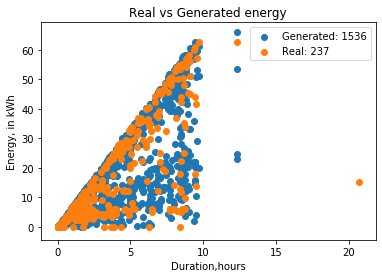

In [129]:
plt.scatter(generated3['Duration'], generated3['Energy'])
plt.scatter(session_df_Copy['hours'], session_df_Copy['cumEnergy_kWhr'])
plt.legend(['Generated: 1536','Real: 237'])
plt.xlabel('Duration,hours')
plt.ylabel('Energy, in kWh')
plt.title('Real vs Generated energy')


In [130]:
generated3.describe()

,Arrivals,Departures_whole,Departures,maxPower_assigned,Duration,15minTimestepDepart,Power,Energy
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000
mean,8.925130,12.100260,12.599907,5.412794,3.674777,50.377604,4.477528,16.502230
std,2.677739,3.732641,3.742649,1.621218,2.740092,14.964170,2.096488,15.487398
min,4.000000,5.000000,5.119722,3.300000,0.012778,20.000000,0.085855,0.021557
25%,7.000000,9.000000,9.507153,3.300000,1.584306,38.000000,2.368469,4.663074
50%,8.000000,12.000000,12.492778,6.656000,2.706944,50.000000,5.660139,10.699127
75%,11.000000,14.000000,14.987778,6.656000,5.511389,60.000000,6.268860,24.285524
max,18.000000,22.000000,22.838611,6.656000,12.291667,91.000000,6.786785,66.005988


In [131]:
#session_df_Copy[['arriHour','departHour','hours','averagePower','cumEnergy_kWhr']].describe()


In [132]:
selected = ['arriHour','departHour','hours','peakPower_kW','averagePower','cumEnergy_kWhr']
session_df_Copy[selected].describe()


,arriHour,departHour,hours,peakPower_kW,averagePower,cumEnergy_kWhr
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.00000
mean,9.159218,12.952514,3.837900,5.366193,4.023748,16.05452
std,3.022754,3.999367,2.945910,1.931118,2.071387,16.40653
min,4.000000,2.000000,0.012778,0.000000,0.000000,0.00000
25%,7.000000,10.000000,1.602500,3.390750,2.391972,4.24425
50%,8.000000,13.000000,3.022778,6.658000,4.105335,8.42600
75%,11.000000,16.000000,6.087639,6.846500,6.173845,25.89100
max,23.000000,23.000000,20.667222,7.163000,6.743546,62.70200


In [133]:
session_df_Copy[selected].corr()['cumEnergy_kWhr']


arriHour         -0.104889
departHour        0.408736
hours             0.741240
peakPower_kW      0.567842
averagePower      0.613946
cumEnergy_kWhr    1.000000
Name: cumEnergy_kWhr, dtype: float64

In [134]:
session_df_Copy[selected].corr()

,arriHour,departHour,hours,peakPower_kW,averagePower,cumEnergy_kWhr
arriHour,1.000000,0.580588,-0.035254,0.066747,0.068280,-0.104889
departHour,0.580588,1.000000,0.581758,0.212969,0.102805,0.408736
hours,-0.035254,0.581758,1.000000,0.258468,0.100537,0.741240
peakPower_kW,0.066747,0.212969,0.258468,1.000000,0.802160,0.567842
averagePower,0.068280,0.102805,0.100537,0.802160,1.000000,0.613946
cumEnergy_kWhr,-0.104889,0.408736,0.741240,0.567842,0.613946,1.000000


In [135]:
generated3.corr()


,Arrivals,Departures_whole,Departures,maxPower_assigned,Duration,15minTimestepDepart,Power,Energy
Arrivals,1.000000,0.684022,0.681991,0.004230,-0.045723,0.682149,-0.005577,-0.037768
Departures_whole,0.684022,1.000000,0.997016,-0.002873,0.693353,0.996572,0.003061,0.550620
Departures,0.681991,0.997016,1.000000,-0.003318,0.699413,0.999820,0.002171,0.554772
maxPower_assigned,0.004230,-0.002873,-0.003318,1.000000,-0.008666,-0.003437,0.939770,0.455254
Duration,-0.045723,0.693353,0.699413,-0.008666,1.000000,0.699012,0.008415,0.794663
15minTimestepDepart,0.682149,0.996572,0.999820,-0.003437,0.699012,1.000000,0.001828,0.554038
Power,-0.005577,0.003061,0.002171,0.939770,0.008415,0.001828,1.000000,0.492793
Energy,-0.037768,0.550620,0.554772,0.455254,0.794663,0.554038,0.492793,1.000000


In [136]:
not_zero = real[real['cate_Power']!=0]
sum(not_zero['cate_Power']==3.3)/len(not_zero)
sum(not_zero['cate_Power']==6.656)/len(not_zero)


0.6347826086956522

In [137]:
# Need to check if arrival and duration are independent variables 


In [138]:
# These are discrete choices 

# Drop Zero charging cars 


sta = session_df_Copy['startChargeTime'].astype('datetime64')

real['Arri'] = sta.dt.hour + sta.dt.minute/60 + sta.dt.second/3600




In [139]:
real = real.sort_values(by='Arri').reset_index(drop=True)


Text(0.5, 1.0, 'Duration Based on Arrivals')

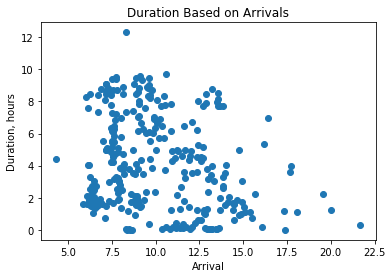

In [140]:
plt.scatter(real['Arri'], real['hours'])
plt.xlabel('Arrival')
plt.ylabel('Duration, hours')
plt.title('Duration Based on Arrivals')


In [141]:
# Drop the events where there was no energy delivered


In [142]:
# generated3.describe()

real[['hours','Arri']].corr()

,hours,Arri
hours,1.000000,-0.094595
Arri,-0.094595,1.000000


In [143]:
generated3[['Arrivals','Duration']].corr()

,Arrivals,Duration
Arrivals,1.000000,-0.045723
Duration,-0.045723,1.000000


In [144]:
# Putting the values into bins
np.random.seed(40)

_bins = np.arange(11)
generated3['Duration_whole'] = generated3['Departures_whole'] - generated3['Arrivals']
generated3['bins'] = pd.cut(generated3['Duration'], _bins)

real_size = generated3.sample(len(real))


In [145]:
#[int(i) for i in generated3['Duration']]

# [int(j) for j in real['hours']]

ty = real_size.groupby(['Arrivals','Duration_whole']).count()

#ty.dropna()['Duration'].index.levels[0]

real_size['Pairs'] = [[ar,du] for ar,du in zip(real_size['Arrivals'],real_size['Duration_whole'])]


#plt.bar(real['arriHour'],real['departHour']-real['arriHour'])

# ty['Departures_whole']
real['bins'] = pd.cut(real['hours'], _bins)



df4 = pd.DataFrame({"Real": real.sort_values(by='bins')['bins'],"Gen":real_size.sort_values(by='bins')['bins']})



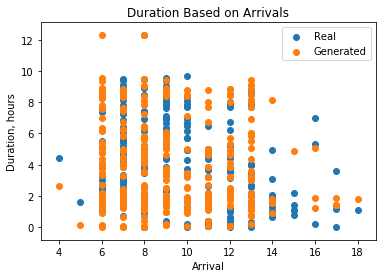

In [146]:
# Real
plt.scatter(real['arriHour'], real['hours'])

# Generated
plt.scatter(real_size['Arrivals'], real_size['Duration'])
plt.xlabel('Arrival')
plt.ylabel('Duration, hours')
plt.title('Duration Based on Arrivals')
plt.legend(['Real', 'Generated'])


In [147]:
#plt.scatter(real_size['Arrivals'], real_size['']
gen_count = real_size.groupby(['Arrivals']).count()
#['Departures_whole'].values
#count = count.reindex(levels, fill_value=0)

gen_count['Duration']

real_count = real.groupby(['arriHour']).count()
# Filling missing value with 0

lev = real_count.index
re = gen_count.reindex(lev,fill_value=0)

duration1 = re['Duration']


In [148]:



from scipy.stats import chisquare

chisquare(re['Duration'].values, f_exp=real_count['hours'])


Power_divergenceResult(statistic=14.820309157391739, pvalue=0.3905474309703165)

In [149]:
# real['Whole_hour'] = real['departHour'] - real['arriHour']
b1 = real.groupby('bins').count()['hours']



In [150]:

# 
# ti = real[['arriHour']].unique()
b2 = real_size.groupby('bins').count()['Duration']
b2.values


array([ 37, 111,  31,  32,  35,  24,  12,  12,  42,   9])

In [151]:
chisquare(b2.values,b1.values)




Power_divergenceResult(statistic=16.58639761897125, pvalue=0.05560089326329335)

In [152]:
b10 = np.arange(1,11)

plotting = pd.DataFrame({'Real': b1,'Generated':b2})

Text(0.5, 1.0, 'Counts According to Duration')

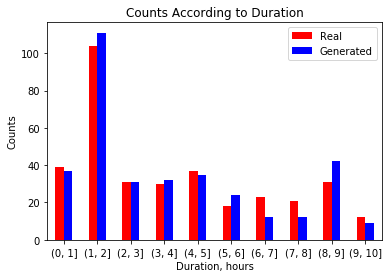

In [153]:
# plt.bar(b10,b2, facecolor='')
# plt.bar(b10,b1, facecolor='Blue')

plotting.plot.bar(rot=0,color={'Red','Blue'})
plt.xlabel('Duration, hours')
plt.ylabel('Counts')
plt.title('Counts According to Duration')



In [154]:
# The following is for 

dat = [[b1.values],[b2.values]]

In [155]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(dat)


In [156]:
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')



p value is 0.4141552738516757
Independent (H0 holds true)


In [157]:
co2 = real_size.groupby('Arrivals').count()
plot2 = pd.DataFrame({'Real': real.groupby('arriHour').count()['hours'], "Generated": re['Duration']})

Text(0.5, 1.0, 'Counts during each hour')

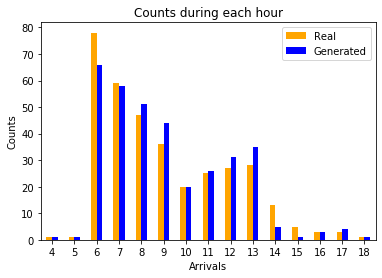

In [158]:
plot2.plot.bar(rot=0,color={'Orange','Blue'})
plt.xlabel('Arrivals')
plt.ylabel('Counts')
plt.title('Counts during each hour')


Power_divergenceResult(statistic=6.483516042115289, pvalue=0.6907187616965449)

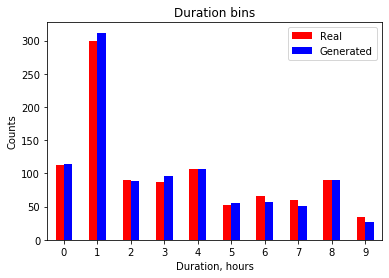

In [159]:
gen3 = (1000*generated3.groupby('bins').count()['Departures_whole']/len(generated3))

# Real 
r5 = (1000*real.groupby('bins').count()['hours']/len(real))

plot_du = pd.DataFrame({'Real':r5.values, 'Generated': gen3.values})
plot_du.plot.bar(rot=0,color={'red','Blue'})
plt.xlabel('Duration, hours')
plt.ylabel('Counts')
plt.title('Duration bins')

chisquare(gen3.values,r5.values)


In [160]:
sum(gen3.values)

997.3958333333334

In [161]:
sum(r5.values)

997.1181556195963

In [162]:
# Fond the way the way 
# As more is observed, t

# Now it is good time to divide energy, 

#real.groupby('departHour').count()['hours']
le_de = real.groupby('departHour').count().index
de = real_size.groupby('Departures_whole').count().reindex(le_de,fill_value=0)


In [163]:
d3 = real_size.groupby('Departures_whole').count()

plot3 = pd.DataFrame({'Real': real.groupby('departHour').count()['hours'], "Generated": de['Departures']})



In [164]:
final = (generated3.groupby('Departures_whole').count()['Departures'])/len(generated3)

# Index 
le_2 = generated3.groupby('Departures_whole').count().index



In [165]:
real_final =  real.groupby('departHour').count().reindex(le_2,fill_value= 0)['hours']/len(real)


In [166]:
de_real = np.round(200*real_final)
de_gen = np.round(200*final)


In [167]:
plot4 = pd.DataFrame({'Real': de_real, "Generated": de_gen})



Text(0.5, 1.0, 'Counts during each Arrival')

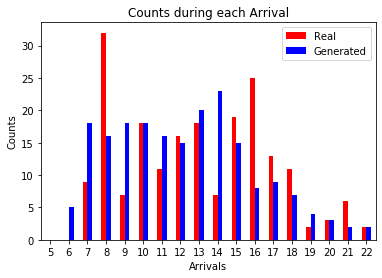

In [168]:
plot4.plot.bar(rot=0,color={'Red','Blue'})
plt.xlabel('Arrivals')
plt.ylabel('Counts')
plt.title('Counts during each Arrival')


In [169]:
chisquare(de_real,de_gen)


Power_divergenceResult(statistic=nan, pvalue=nan)

In [170]:

bins_po= np.arange(8)
powe = pd.cut(generated3['Power'], bins_po)

In [171]:
generated3['Power_bins'] = powe

In [172]:
# Let's multiply the bins by the appropiate number from real (if you are lucky you will get the exact value)

ge_no = np.round(237*generated3.groupby('Power_bins').count()['Duration']/len(generated3))


In [173]:
real_pow = pd.cut(real['averagePower'], bins_po)
real['Power_bins'] = real_pow
real_Po = real.groupby('Power_bins').count()['hours']

In [174]:
plot10 = pd.DataFrame({'Real': real_Po, "Generated": ge_no})


P_Value 3.289148460512263e-10


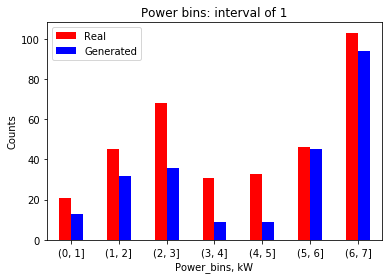

In [175]:
plot10.plot.bar(rot=0,color={'red','Blue'})
plt.xlabel('Power_bins, kW')
plt.ylabel('Counts')
plt.title('Power bins: interval of 1')
pvp = chisquare(ge_no, real_Po).pvalue
print("P_Value",(pvp))


In [176]:
# The Real_Po is the Expected Frequency 
chisquare(ge_no, real_Po)


Power_divergenceResult(statistic=55.73759371036335, pvalue=3.289148460512263e-10)

In [177]:
energy_bins = np.arange(0,66,5)

energ = pd.cut(generated3['Energy'], energy_bins)
generated3['Energy_bins'] = energ


In [178]:

rea = pd.cut(real['cumEnergy_kWhr'], energy_bins)
real['Energy_bins'] = rea


In [179]:
ene_re = real.groupby('Energy_bins').count()['hours']
ge_en = np.round(236*generated3.groupby('Energy_bins').count()['Energy']/len(generated3))
sum(ge_en.values)


235.0

P_Value 0.0


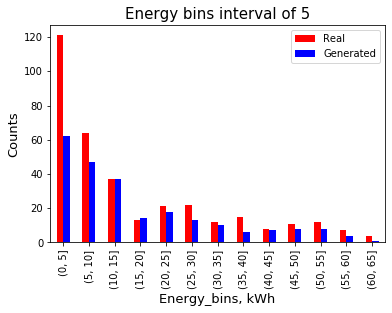

In [180]:

plot11 = pd.DataFrame({'Real': ene_re, "Generated": ge_en})
plot11.plot.bar(rot=0,color={'red','Blue'})
plt.xlabel('Energy_bins, kWh', size = 13)
plt.ylabel('Counts', size = 13)
plt.title('Energy bins interval of 5',size = 15)
plt.xticks(rotation = 90)

pv = chisquare(ene_re.values,ge_en.values).pvalue
print("P_Value",np.round(pv,3))

In [181]:
chisquare(ene_re.values,ge_en.values)


Power_divergenceResult(statistic=97.5141524055903, pvalue=1.7060351517650016e-15)

In [182]:
sum(real['cate_Power']==6.656)


219

In [183]:
# Normalize the total generated, 
sum(real['cate_Power']==3.3)/sum(real['cate_Power']!=0)


0.3652173913043478

In [184]:
sum(real['cate_Power']==6.656)/sum(real['cate_Power']!=0)


0.6347826086956522

In [185]:
generated3.groupby('bins').count()['Duration']/len(generated3)


bins
(0, 1]     0.113932
(1, 2]     0.311849
(2, 3]     0.087891
(3, 4]     0.096354
(4, 5]     0.106771
(5, 6]     0.055990
(6, 7]     0.056641
(7, 8]     0.050781
(8, 9]     0.089844
(9, 10]    0.027344
Name: Duration, dtype: float64

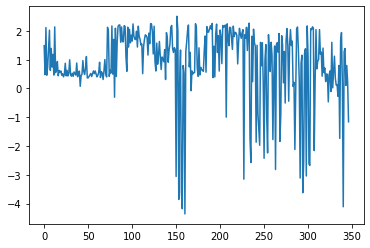

In [186]:
plt.plot(np.arange(len(real)),np.log(real['hours']))


In [187]:
from scipy import stats
import seaborn as sns 
# real = real.sort_values(by='Arri')
# stats.linregress(real['', y)



In [188]:
coef = stats.linregress(real['Arri'], real['hours'])

# Coefficient of determination 
coef.rvalue**2



0.008948185026114733

In [189]:
# With an rvalue of -0.11 and p_value of 0.08 

# If we ch
# sns.boxplot(x="arriHour",y='averagePower', data=real)



Text(0.5, 1.0, 'Boxplot: SlrpEV Data')

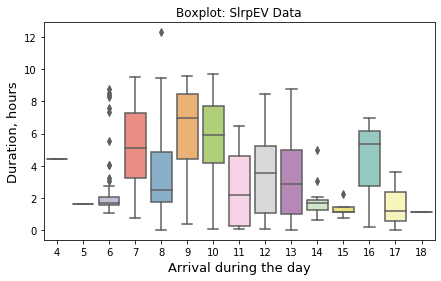

In [190]:
plt.figure(figsize=(7, 4))
sns.boxplot(x="arriHour",y='hours', data=real, palette="Set3")
plt.xlabel('Arrival during the day',size =13)
plt.ylabel('Duration, hours',size =13)
plt.title('Boxplot: SlrpEV Data')


Text(0.5, 1.0, 'Median duration based on Arrival')

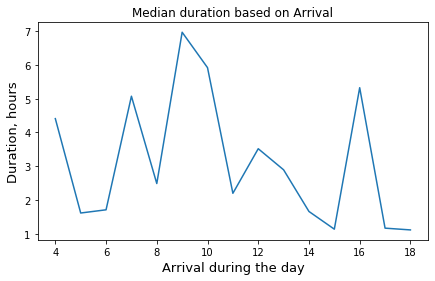

In [191]:
plt.figure(figsize=(7, 4))
py = real.groupby('arriHour').median()
plt.plot(py.index, py['hours'])
plt.xlabel('Arrival during the day',size=13)
plt.ylabel('Duration, hours', size = 13)
plt.title('Median duration based on Arrival')


The following is the documentation for scipy-stats

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [192]:


stat = stats.pearsonr(real['Arri'],real['hours'])
stat[0]**2


0.008948185026114738

Text(13, 6, 'R^2 = 0.009,  2_sided: p_value = 0.078')

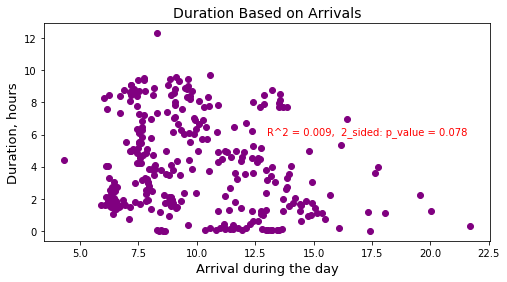

In [193]:
plt.figure(figsize=(8, 4))
plt.scatter(real['Arri'], real['hours'], color = 'Purple')
plt.xlabel('Arrival during the day', size = 13)
plt.ylabel('Duration, hours', size =13)
plt.title('Duration Based on Arrivals', size = 14)
plt.text(13, 6,'R^2 = {:.3f},  2_sided: p_value = {:.3f}'.format(stat[0]**2, stat[1]), color='Red', size=10)


Text(0, 0.5, 'Arrival hour during the day')

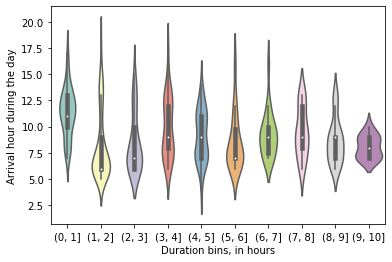

In [194]:
sns.violinplot(x="bins",y='arriHour', data=real, palette="Set3")
plt.xlabel('Duration bins, in hours')
plt.ylabel('Arrival hour during the day')



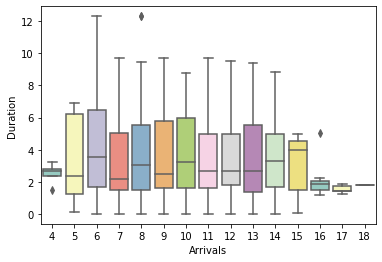

In [195]:
sns.boxplot(x="Arrivals",y='Duration', data=generated3, palette="Set3")



Text(0.5, 1.0, 'Median for Arrival')

<Figure size 576x288 with 0 Axes>

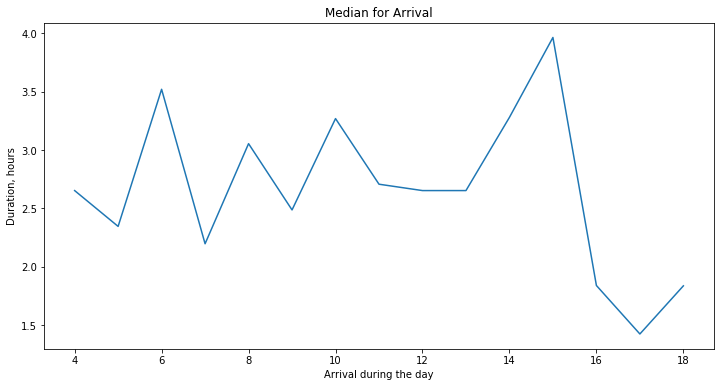

In [196]:
plt.figure(figsize=(8, 4))
gt = generated3.groupby('Arrivals').median()
plt.figure(figsize=(12,6))
plt.plot(gt.index, gt['Duration'])
plt.xlabel('Arrival during the day')
plt.ylabel('Duration, hours')
plt.title('Median for Arrival')


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0300770] [loc=16.324 scale=16.335]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0190460] [loc=0.009 scale=16.315]
[distfit] >[pareto    ] [0.22 sec] [RSS: 0.0190331] [loc=-5544.701 scale=5544.710]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 0.0274981] [loc=11.458 scale=12.940]
[distfit] >[t         ] [0.11 sec] [RSS: 0.0213560] [loc=7.099 scale=6.249]
[distfit] >[genextreme] [0.33 sec] [RSS: 0.0176768] [loc=6.450 scale=6.948]
[distfit] >[gamma     ] [0.17 sec] [RSS: 0.0192331] [loc=0.009 scale=21.163]
[distfit] >[lognorm   ] [0.34 sec] [RSS: 0.0179982] [loc=-0.968 scale=10.605]
[distfit] >[beta      ] [0.34 sec] [RSS: 0.0201656] [loc=0.009 scale=71.122]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0323124] [loc=0.009 scale=62.693]
[distfit] >[loggamma  ] [0.27 sec] [RSS: 0.0300908] [loc=-5487.443 scale=729.618]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


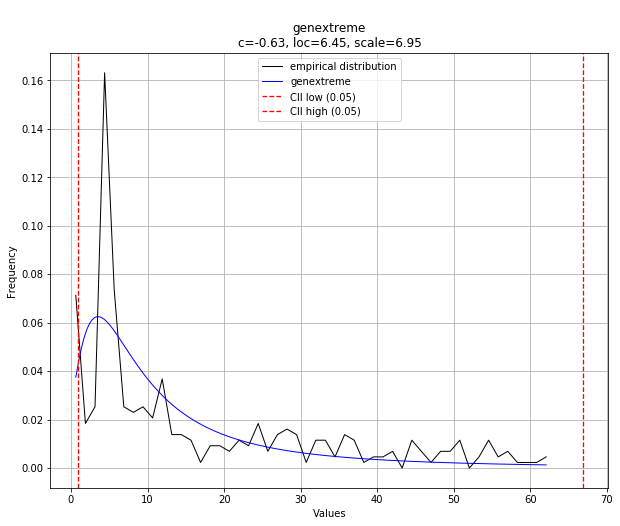

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff75bc15668>)

In [197]:
ener = distfit(todf=True)
ener.fit_transform(real['cumEnergy_kWhr'])
ener.plot()

In [198]:
# ener.plot_summary()



In [199]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [200]:
# Reading different
Train = real[['hours','averagePower','cumEnergy_kWhr','cate_Power']]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(Train)


In [201]:
# Split the data into train and test set
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))



242 105


In [202]:
a = real['hours']>5
b = real['cumEnergy_kWhr']<10
real[a&b].head()

,hours,averagePower,cumEnergy_kWhr,choice,peakPower,arriHour,departHour,syn_Energy,cate_Power,cate_Energy,cate_Energy_noise,Arri,bins,Power_bins,Energy_bins
131,5.113889,1.571016,8.034,SCHEDULED,6.847,7,13,22.067329,6.656,34.038044,32.961354,7.888333,"(5, 6]","(1, 2]","(5, 10]"
215,8.717222,1.134192,9.887,SCHEDULED,1.289,9,18,39.555361,3.300,28.766833,28.193652,9.784722,"(8, 9]","(1, 2]","(5, 10]"
228,6.457778,0.796559,5.144,SCHEDULED,3.406,10,16,27.714242,3.300,21.310667,21.868839,10.377500,"(6, 7]","(0, 1]","(5, 10]"
255,6.483889,0.924599,5.995,REGULAR,3.359,11,18,27.926184,3.300,21.396833,21.246038,11.601667,"(6, 7]","(0, 1]","(5, 10]"
276,8.001667,0.741596,5.934,SCHEDULED,3.348,12,20,34.962702,3.300,26.405500,27.705772,12.417222,"(8, 9]","(0, 1]","(5, 10]"


In [203]:
real.loc[1,'choice']

'REGULAR'

In [204]:
real.loc[1]

hours                1.61333
averagePower         6.19773
cumEnergy_kWhr         9.999
choice               REGULAR
peakPower              6.572
arriHour                   5
departHour                 7
syn_Energy           5.33567
cate_Power             6.656
cate_Energy          10.7383
cate_Energy_noise    11.0068
Arri                 5.88889
bins                  (1, 2]
Power_bins            (6, 7]
Energy_bins          (5, 10]
Name: 1, dtype: object

In [205]:
real.loc[0:4]

,hours,averagePower,cumEnergy_kWhr,choice,peakPower,arriHour,departHour,syn_Energy,cate_Power,cate_Energy,cate_Energy_noise,Arri,bins,Power_bins,Energy_bins
0,4.410556,5.747122,25.348,REGULAR,6.895,4,8,21.956678,6.656,29.356658,28.815654,4.341111,"(4, 5]","(5, 6]","(25, 30]"
1,1.613333,6.197727,9.999,REGULAR,6.572,5,7,5.335670,6.656,10.738347,11.006839,5.888889,"(1, 2]","(6, 7]","(5, 10]"
2,8.285833,6.038741,50.036,SCHEDULED,7.096,6,14,35.804536,6.656,55.150507,55.568243,6.049167,"(8, 9]","(6, 7]","(50, 55]"
3,1.585000,3.047950,4.831,REGULAR,3.377,6,7,5.610350,3.300,5.230500,4.910791,6.085000,"(1, 2]","(3, 4]","(0, 5]"
4,2.140556,2.101791,4.499,REGULAR,3.405,6,8,8.676913,3.300,7.063833,7.730475,6.111944,"(2, 3]","(2, 3]","(0, 5]"


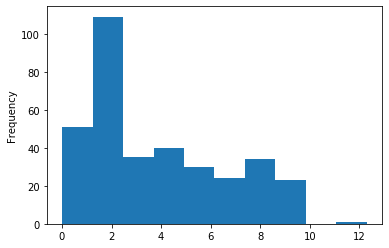

In [206]:
real.hours.plot(kind = "hist")

In [207]:
## Dropped values that have 0 energy and where the arrival day is different from depart 
## 


In [208]:
ar2 = np.arange(11)
p = pd.DataFrame(ar2)
p.rolling(window=4).mean()
def mA(a, n):
    
    q = pd.DataFrame(a).expanding(n).mean()
    
    return q


In [209]:
def cumuAverage(arr,window):
    return pd.DataFrame(arr).expanding(window).mean()[0]



In [210]:
chosen_data = real[['hours','averagePower','cumEnergy_kWhr','peakPower','arriHour']]

dataset = chosen_data.values
dataset = dataset.astype("float32")

In [211]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.3581576 , 0.85217786, 0.40417588, 0.9625855 , 0.        ],
       [0.1303502 , 0.9190263 , 0.15934792, 0.9174927 , 0.07142857],
       [0.6737625 , 0.8954403 , 0.79796785, 0.9906464 , 0.14285716],
       ...,
       [0.17935027, 0.41965297, 0.0998995 , 0.46558705, 0.6428572 ],
       [0.09885983, 0.4717256 , 0.06212815, 0.47731397, 0.6428572 ],
       [0.02447742, 0.45457792, 0.01518511, 0.4689376 , 0.6428572 ]],
      dtype=float32)

In [212]:
train_size = int(len(dataset)*.70)
test_size = len(dataset)-train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset)]
print(len(train), len(test))


242 105


In [213]:
def data_generator(data,look=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-look-1):
        dat = dataset[i:(i+look),0]
        dataX.append(dat)
        dataY.append(dataset[i+look,0])
    return np.array(dataX), np.array(dataY)



